In [71]:
# Using lifelines package to do survival analysis.
import pandas as pd
import numpy as np
import lifelines
import lifelines.statistics
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

/mnt/c/Users/chapmano/Documents/CSE283_Omics/project


In [2]:
# Globals.
RNASEQ_PATH = './rnaseq/KIRC.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt'
CLINICAL_PATH = './clinical/KIRC.merged_only_clinical_clin_format.txt'

In [171]:
# Load data into pandas tables
clinical = pd.read_table(CLINICAL_PATH).transpose()
clinical = clinical.iloc[1:].rename(columns=clinical.iloc[0])
rnaseq = pd.read_table(RNASEQ_PATH).iloc[1:].set_index('Hybridization REF')
print(clinical.shape)
print(rnaseq.shape)

/home/chapmano/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,

(537, 518)
(20531, 606)


In [172]:
# Reformat clinical data table
keep={'patient.bcr_patient_barcode':'patient_barcode',
      #'patient.follow_ups.follow_up.new_tumor_events.new_tumor_event.days_to_new_tumor_event_after_initial_treatment':'days_to_new_tumor',
      'patient.days_to_death':'days_to_death',
      'patient.days_to_last_followup':'days_to_last_followup'
     }
clinical=clinical.loc[:,keep.keys()]
clinical=clinical.rename(mapper=keep,axis=1)
clinical=clinical.set_index('patient_barcode')

clinical=clinical.astype(float)

# Aggregate into days to event
clinical['days_to_event'] = clinical['days_to_death'].mask(clinical['days_to_death'].isna(),other=clinical['days_to_last_followup'])

# Censored column
clinical['observed']=clinical['days_to_death'].notnull()

# Drop negative days-to-event
print(clinical['days_to_event'].dtype)
clinical = clinical[~clinical['days_to_event'].lt(0)]

float64


In [173]:
# Reformat rna table
rna = rnaseq.rename(mapper=(lambda x: x.lower()[:12]),axis=1)
rnaseq = rna.loc[:,~rna.columns.duplicated()]
rnaseq = rnaseq.astype(float)

# Reformat rna table indices to be gene names
def format_gene_name(string):
    return string.split('|')[0]
rnaseq = rnaseq.rename(mapper=format_gene_name,axis='index')
rnaseq=rnaseq.drop('?')
rnaseq=rnaseq.drop_duplicates()



# Want subset of clinical data for which RNA exists
t=set(rnaseq.columns)
data = [True if g in t else False for g in clinical.index]
t=pd.Series(data,clinical.index)
t.name = 'RNAseq'
clinical=clinical[t]

# Write it to a .tsv
'''
f = os.getcwd()+'/rnaseq/KIRC_formatted.tsv'
rnaseq.to_csv(path_or_buf=f,sep='\t')
'''
print(clinical.shape)
print(rnaseq.shape)

(532, 4)
(20222, 533)


# New analysis using ssGSEA sets

In [166]:
HALLMARK = './rnaseq/KIRC_formatted_CH.gct'
# read in .gct as pandas file
def read_gct(input_path):
    df = pd.read_table(input_path,skiprows=2,index_col=0)
    return df
hl = read_gct(HALLMARK)
hl=hl[clinical.index]
h=hl.gt(hl.median(1),axis='rows').transpose()
print(hl.shape)

(147, 532)


/home/chapmano/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


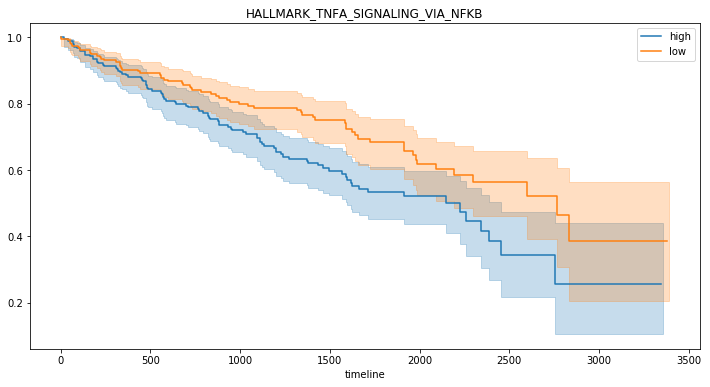

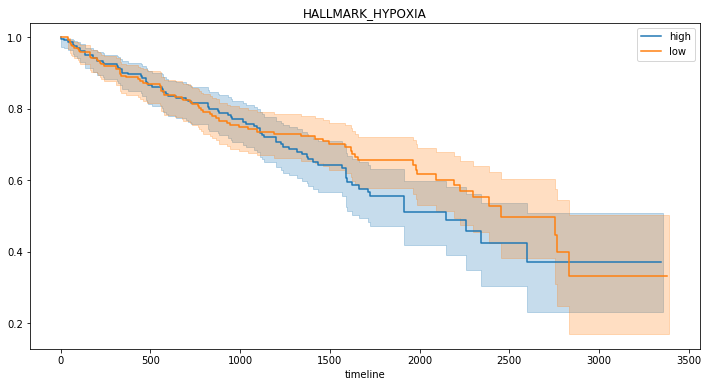

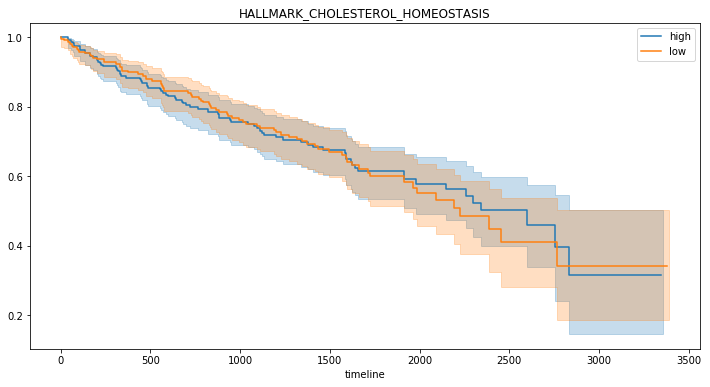

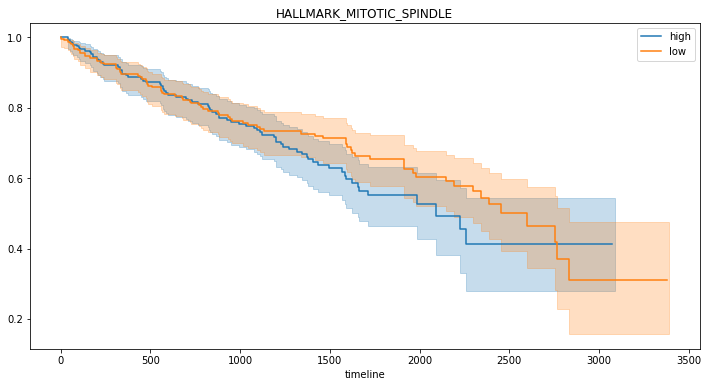

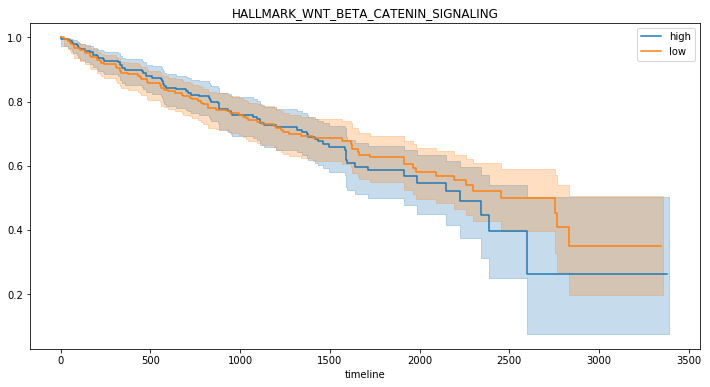

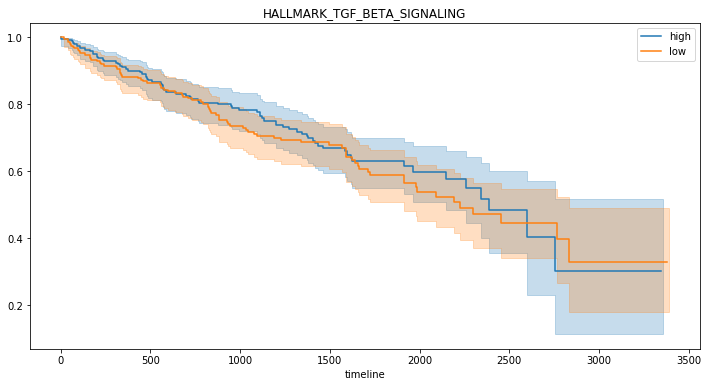

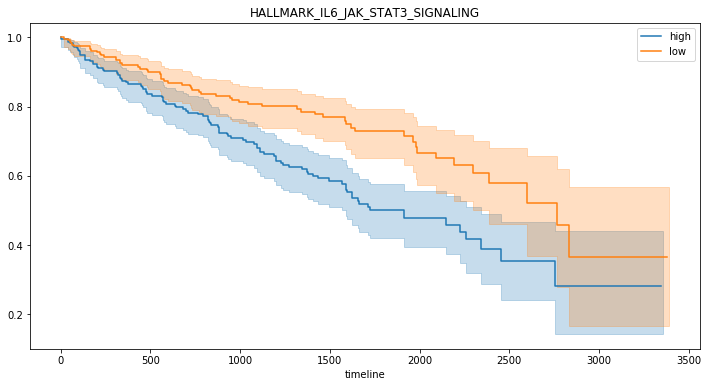

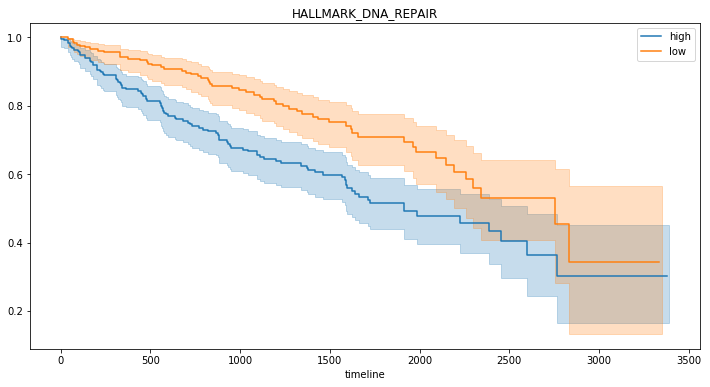

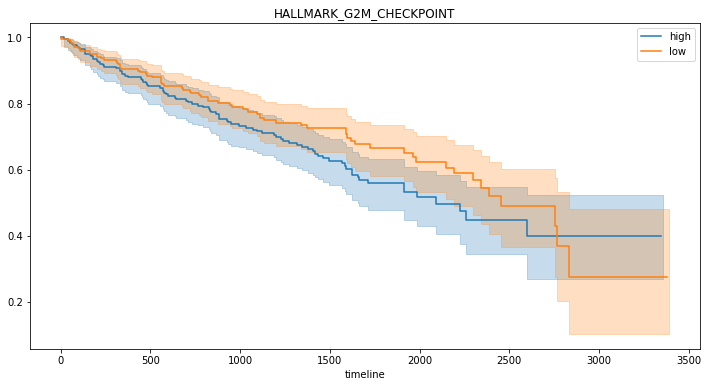

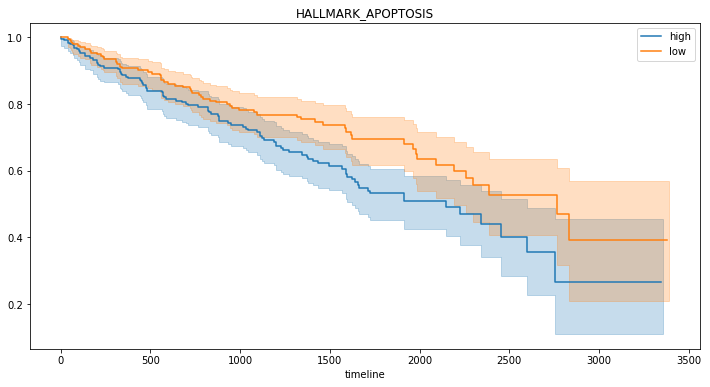

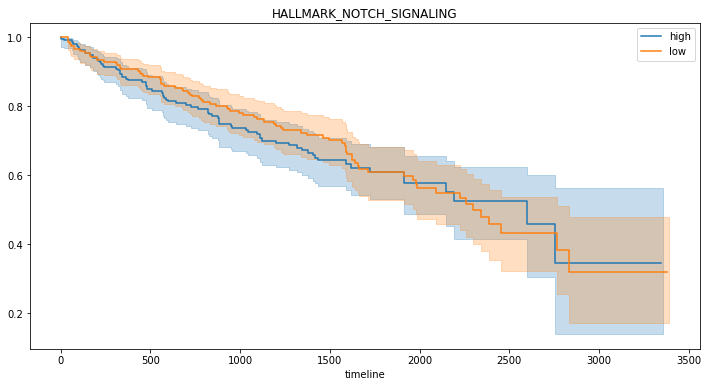

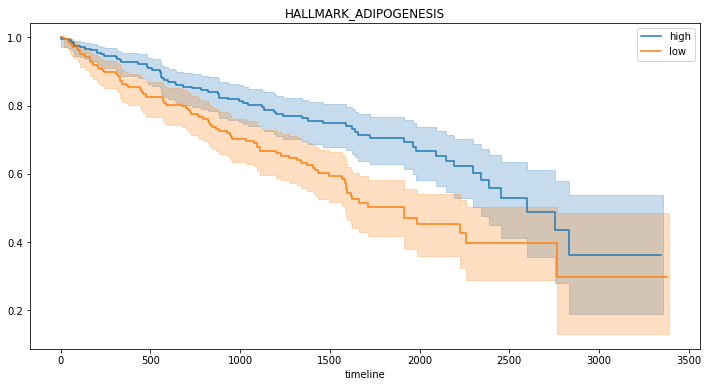

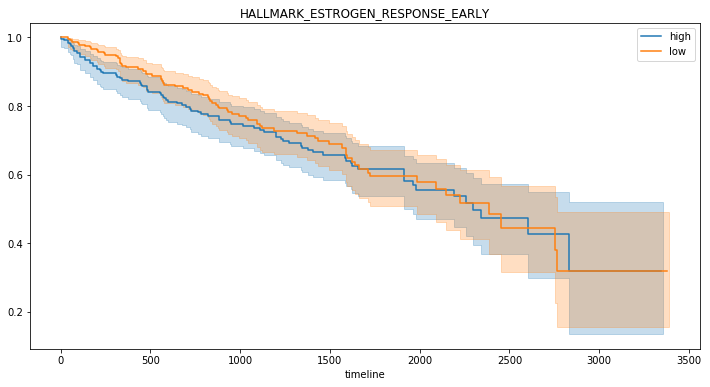

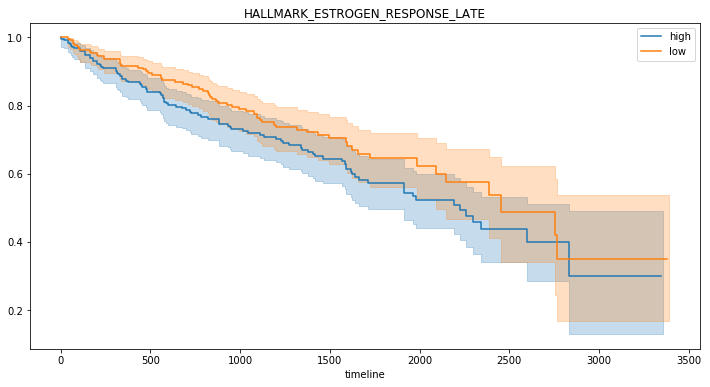

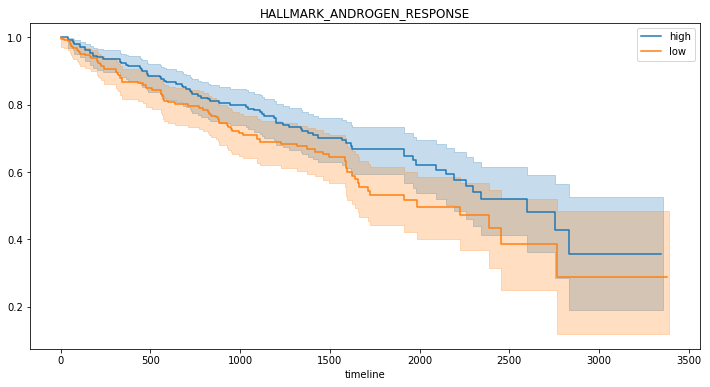

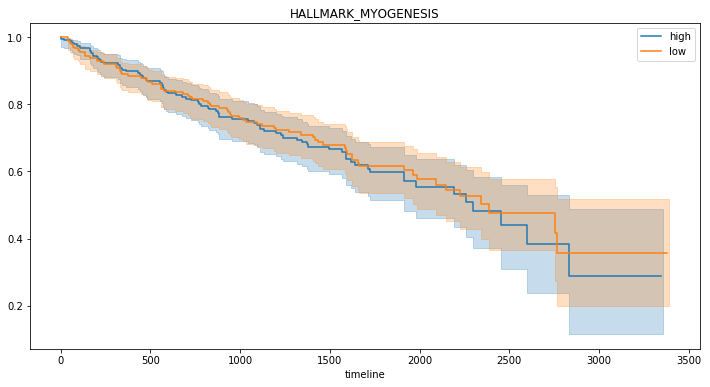

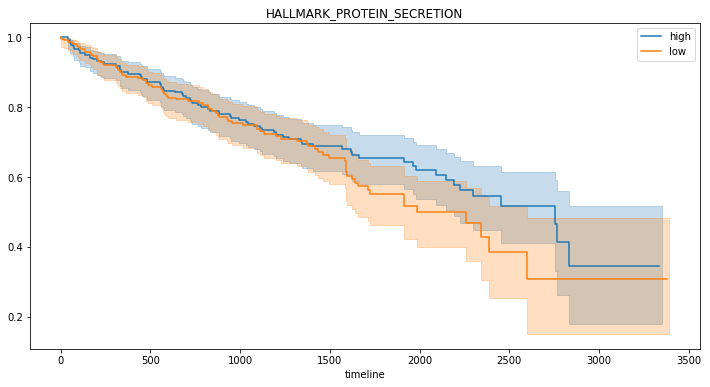

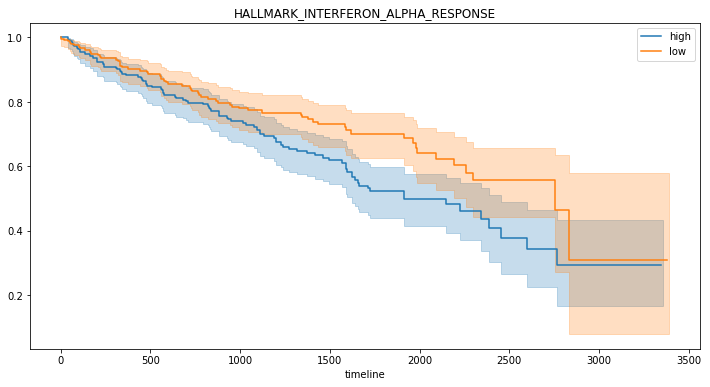

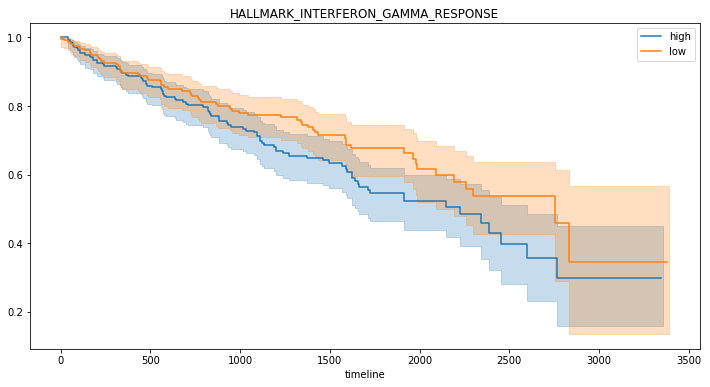

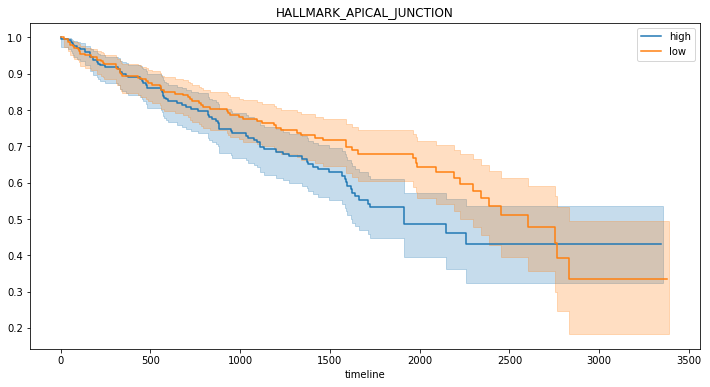

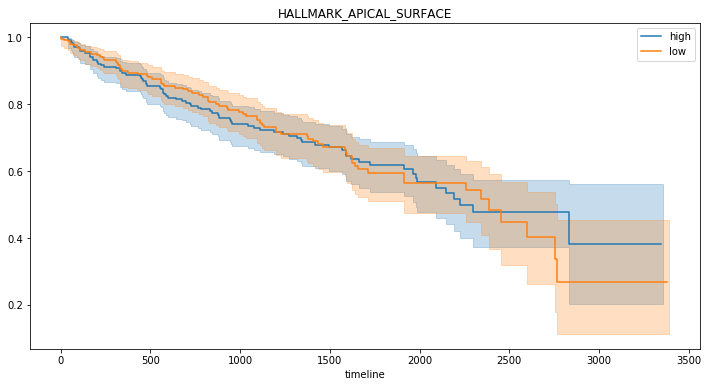

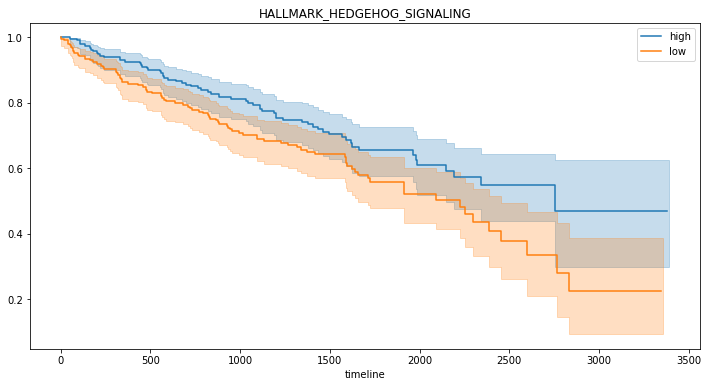

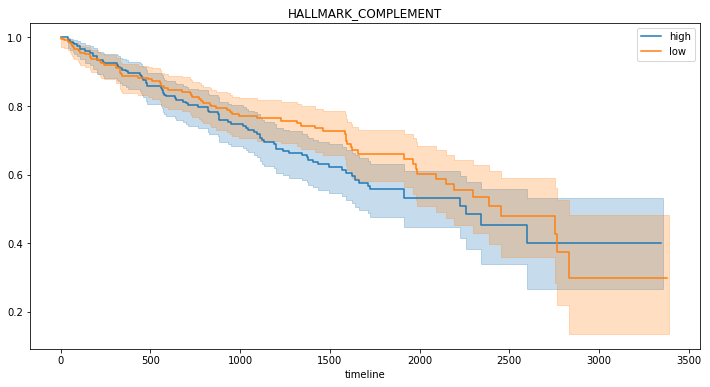

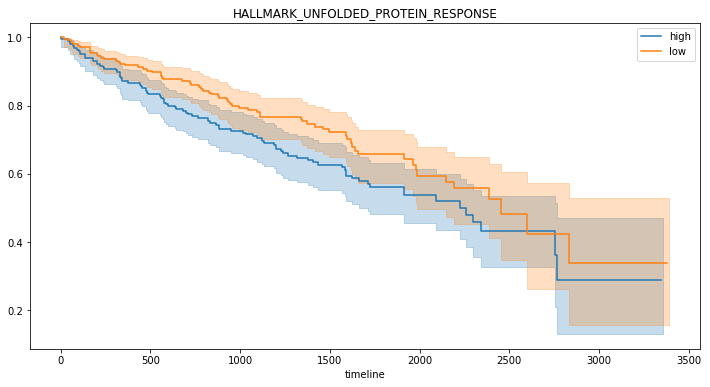

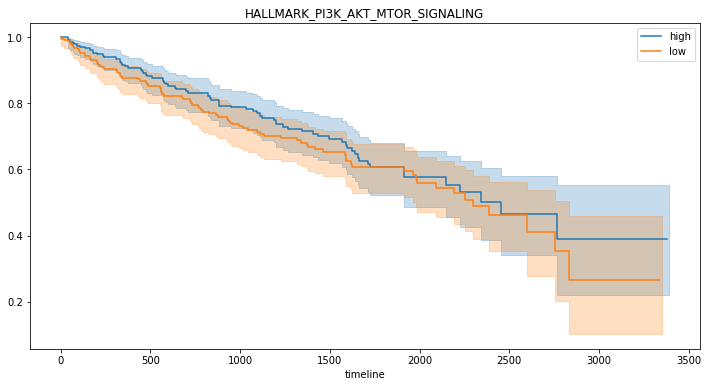

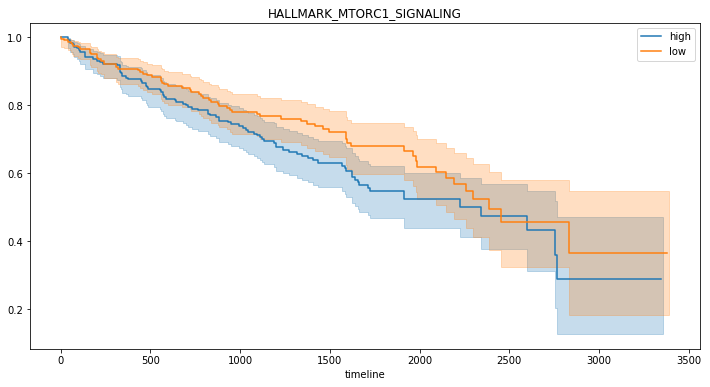

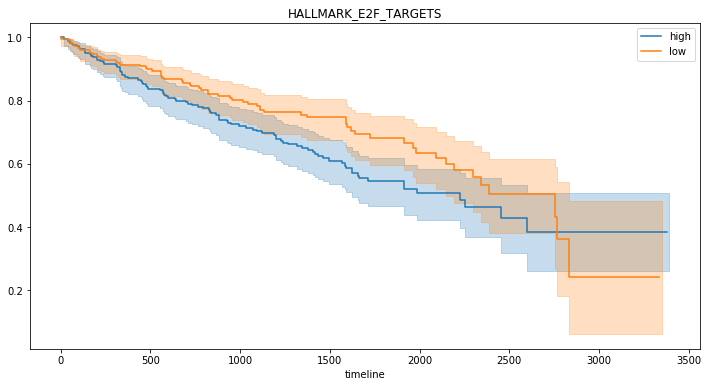

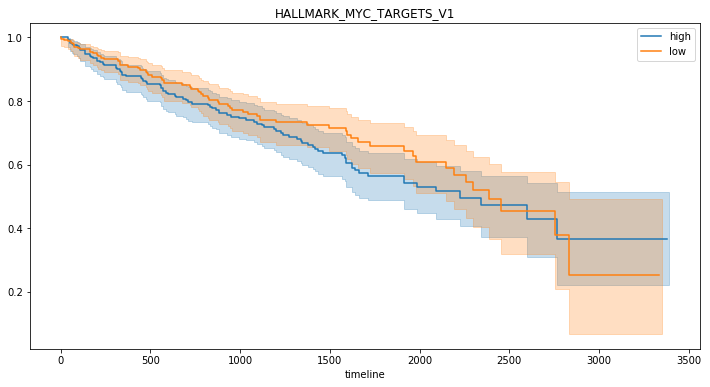

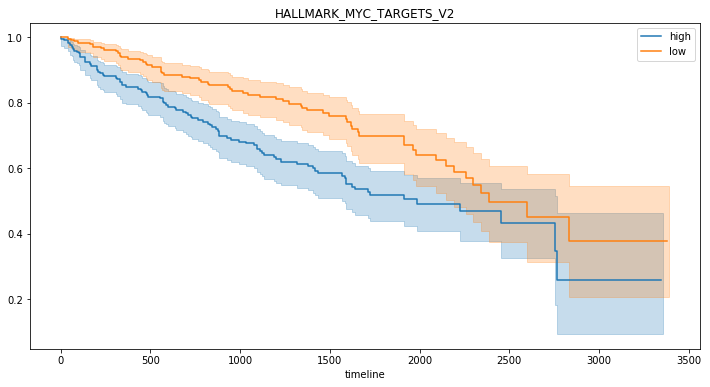

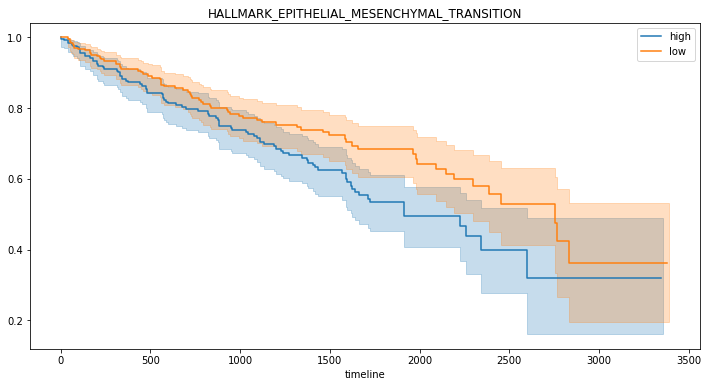

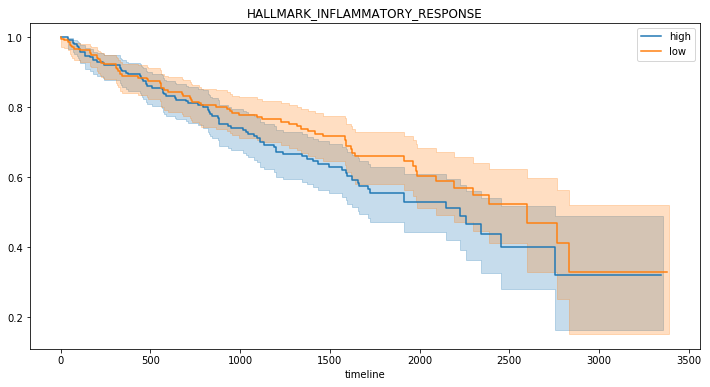

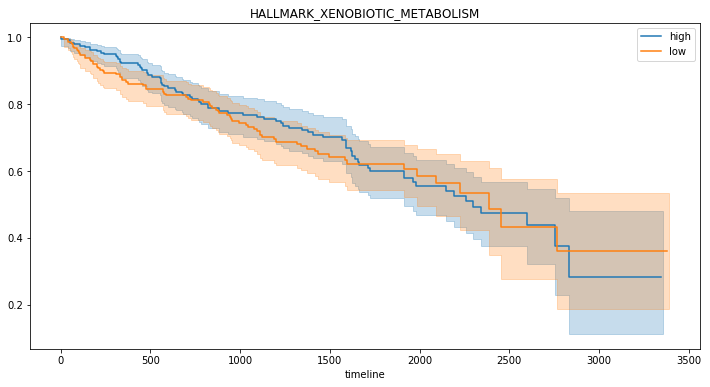

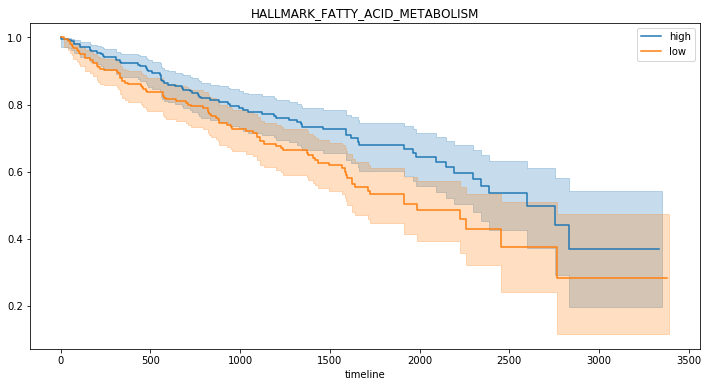

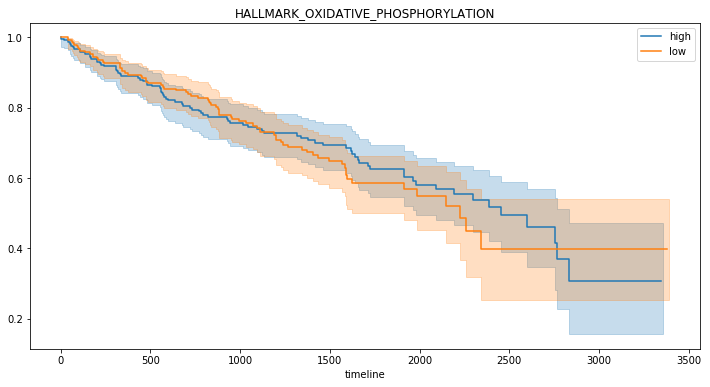

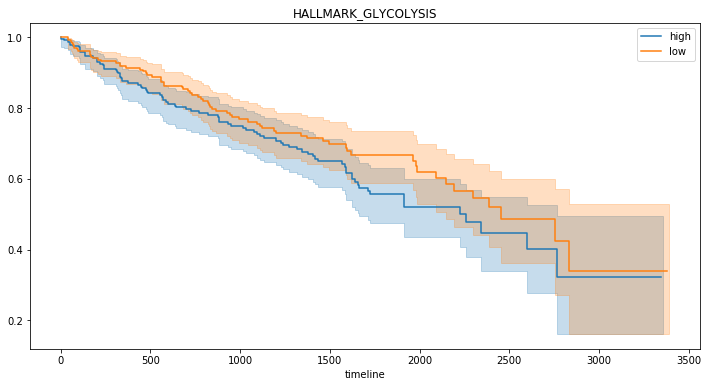

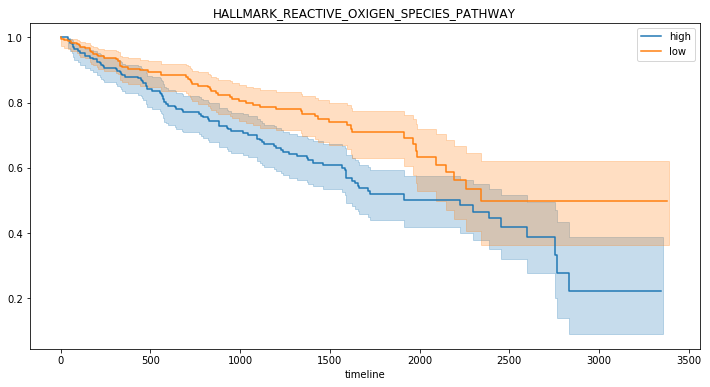

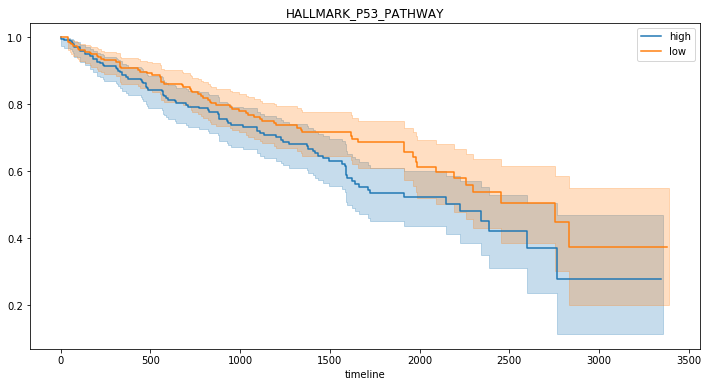

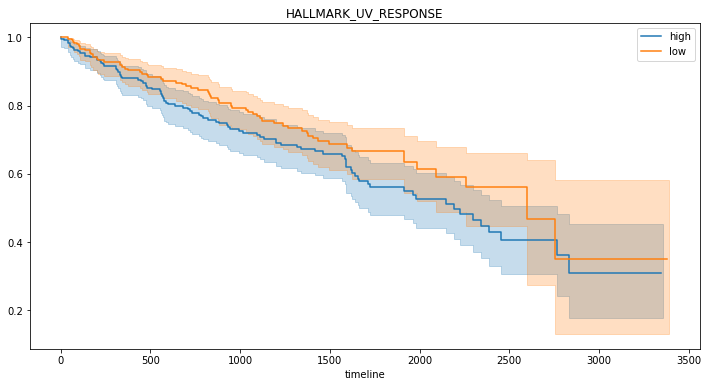

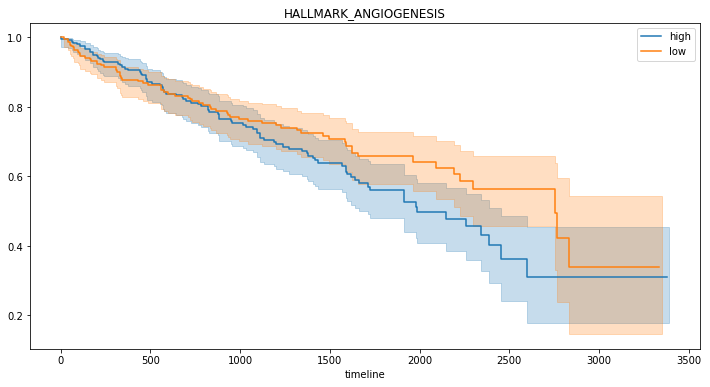

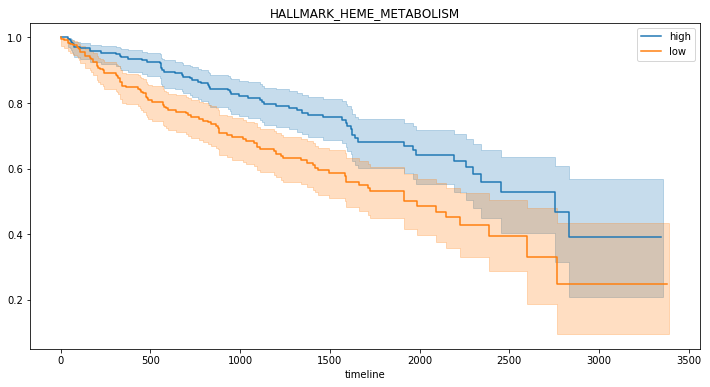

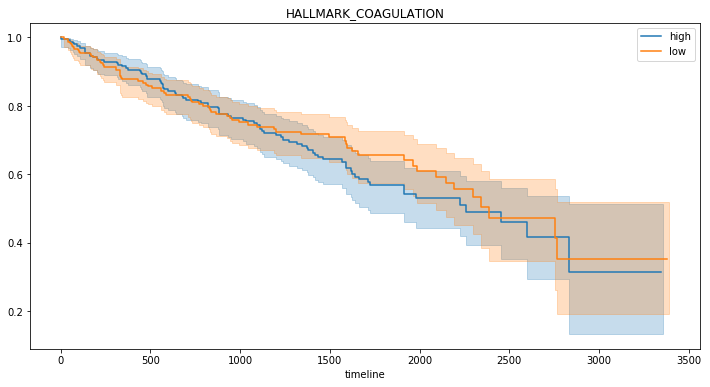

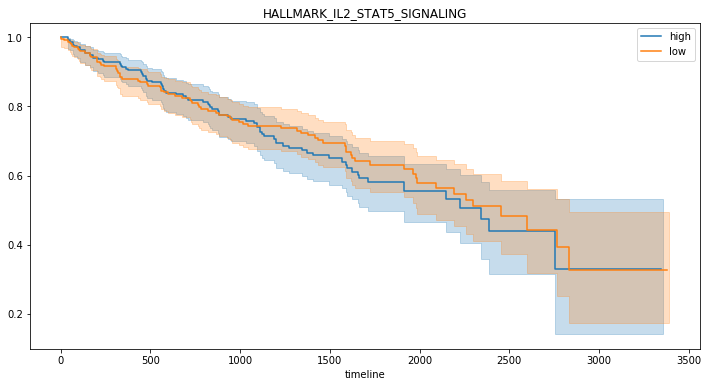

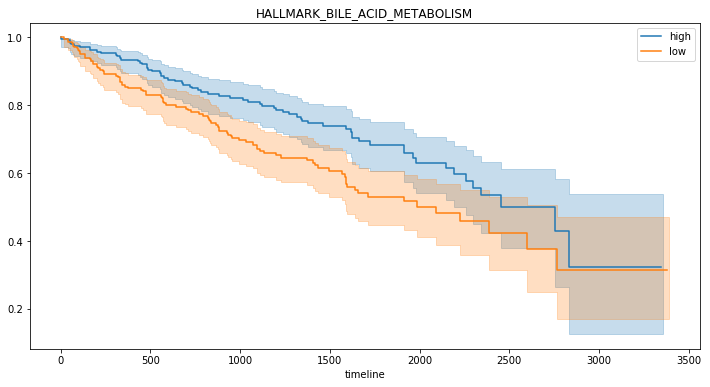

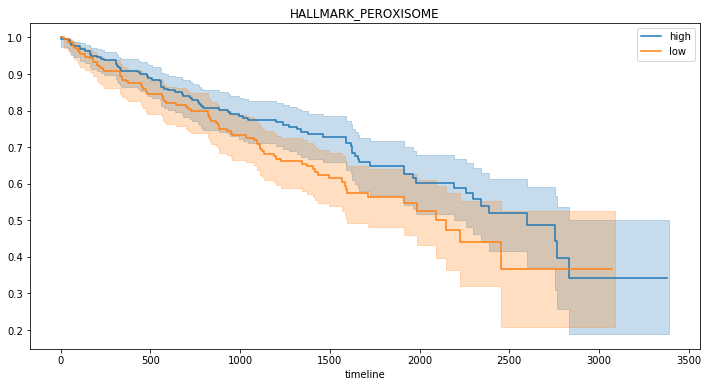

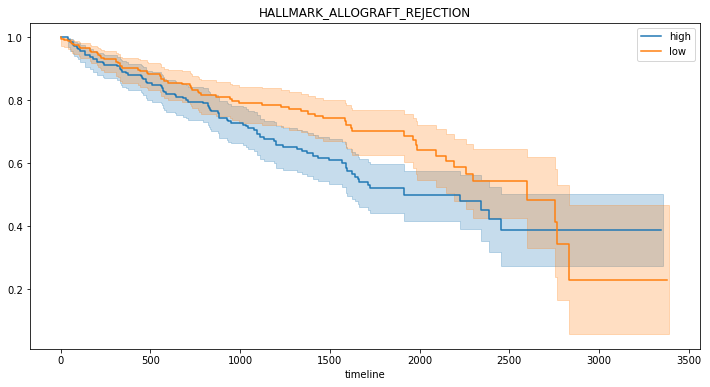

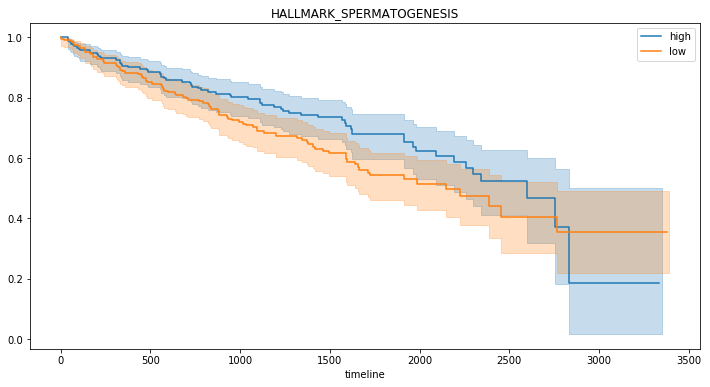

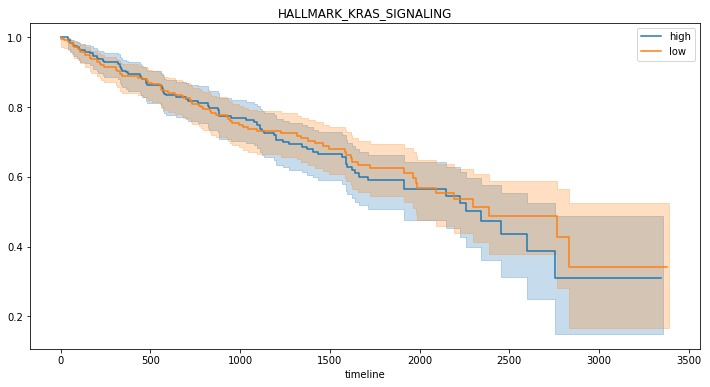

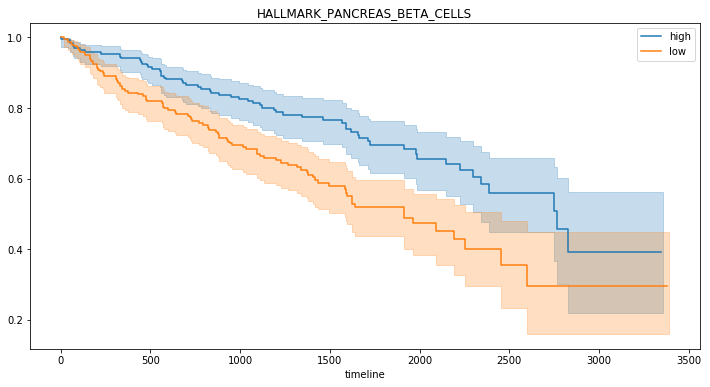

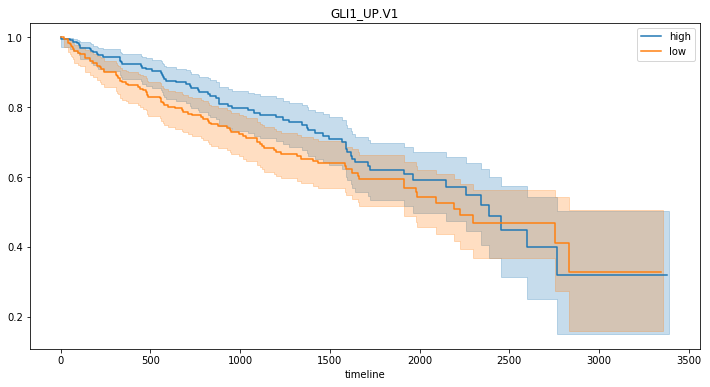

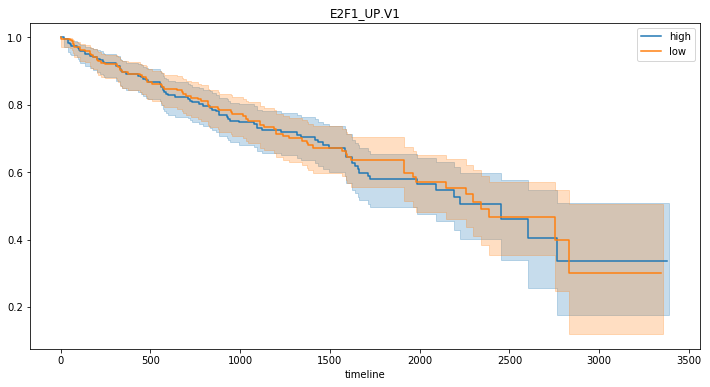

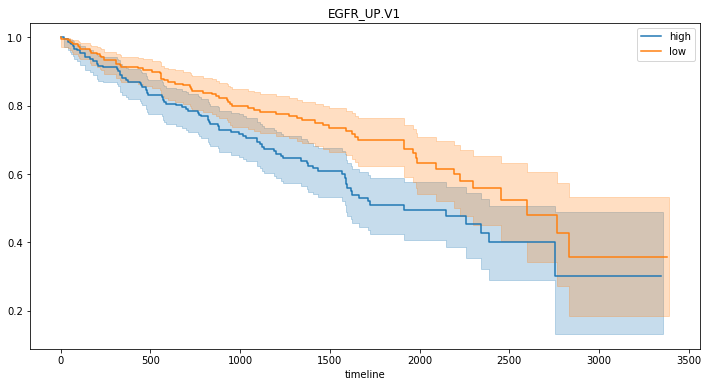

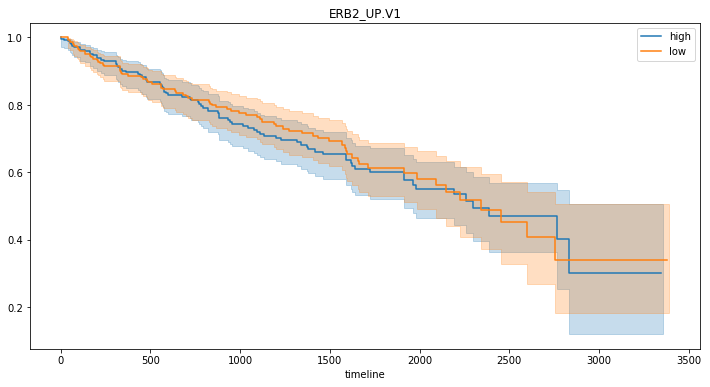

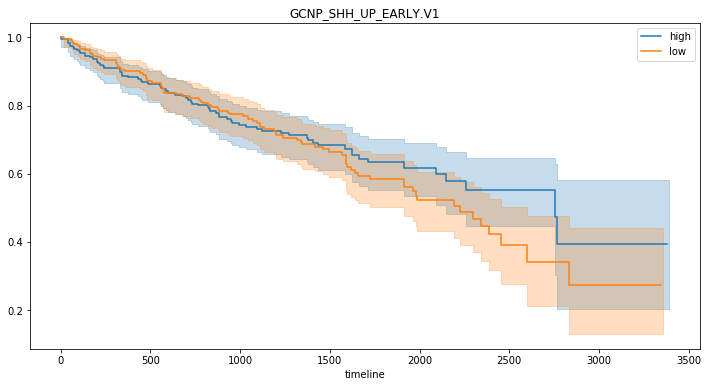

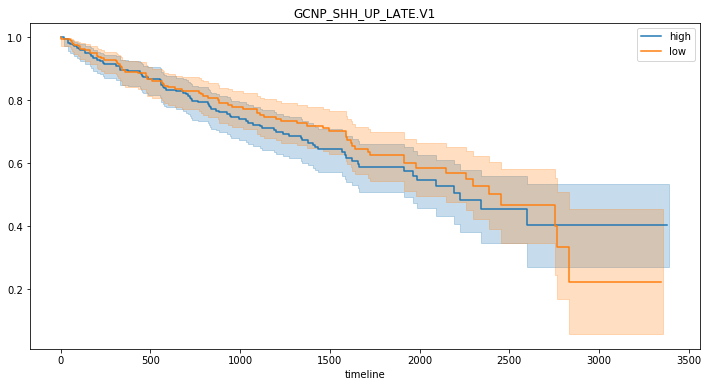

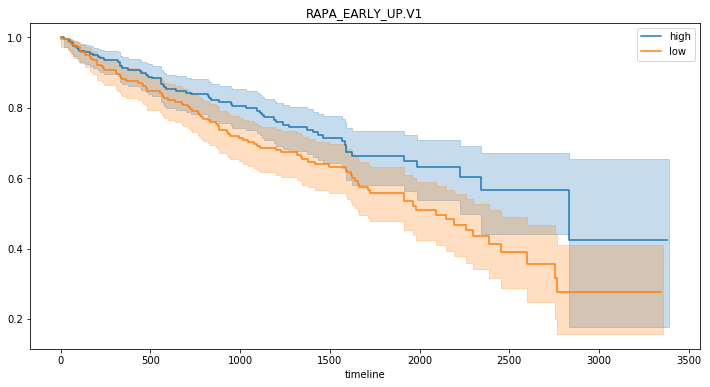

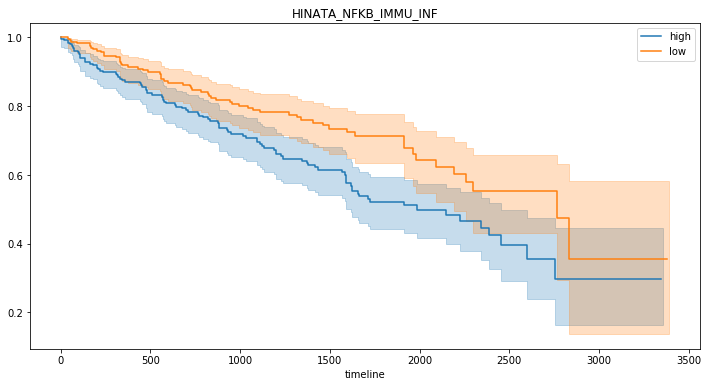

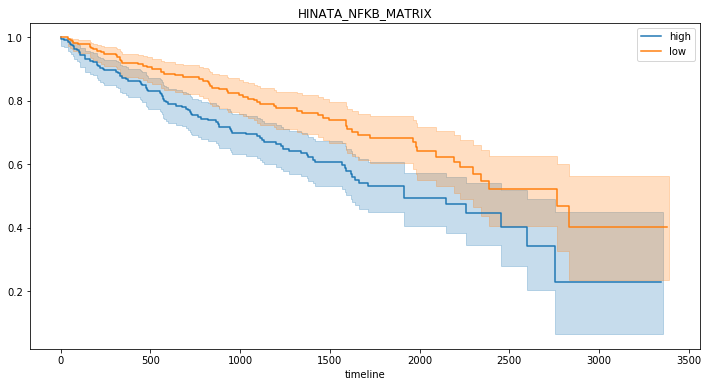

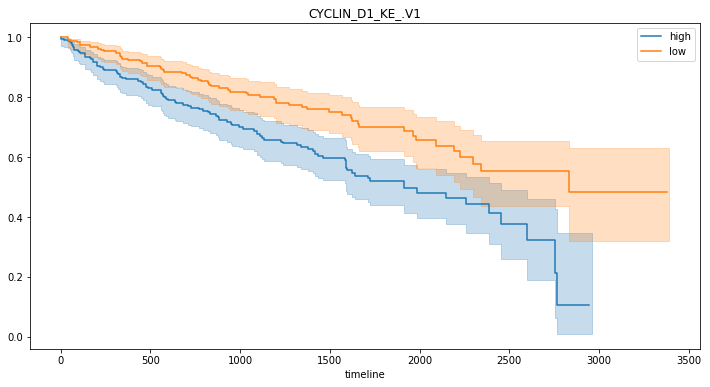

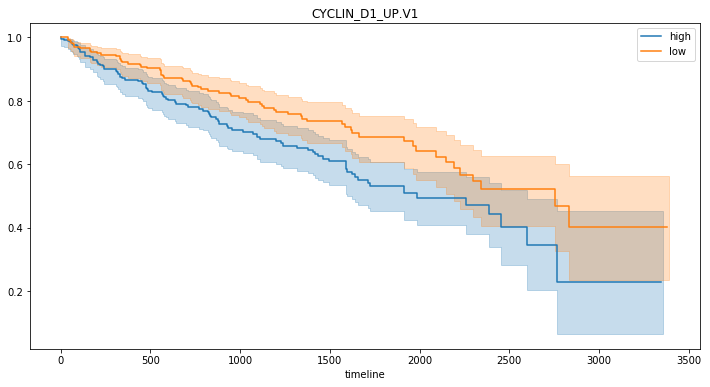

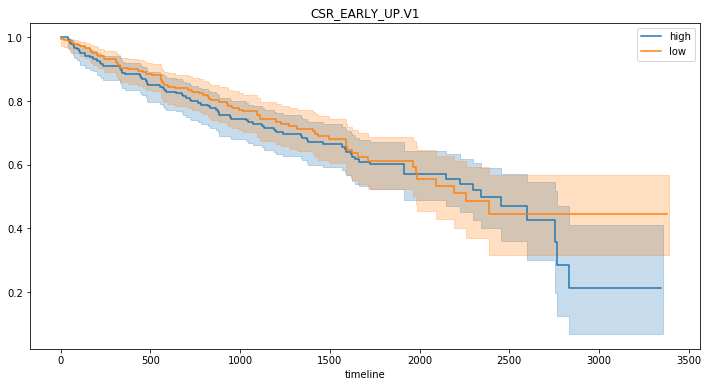

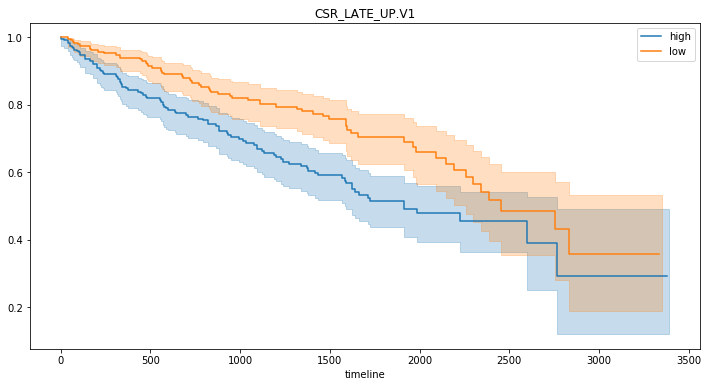

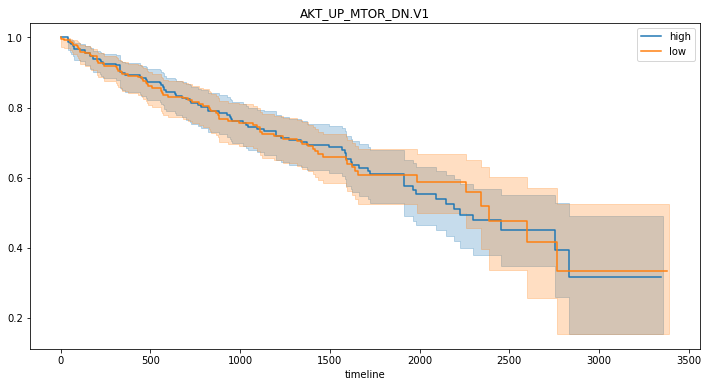

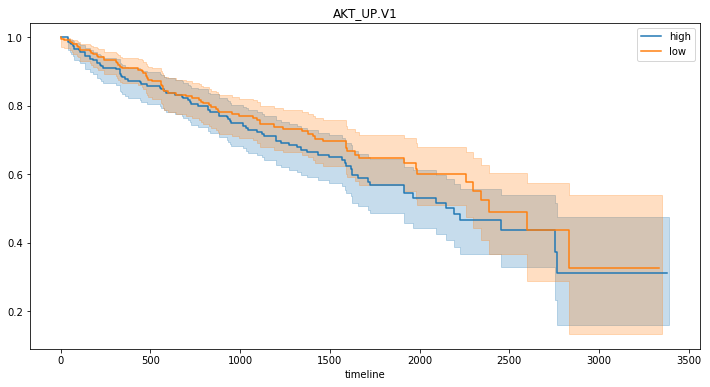

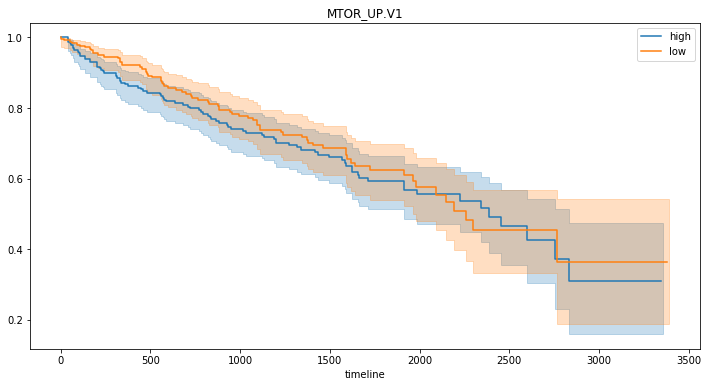

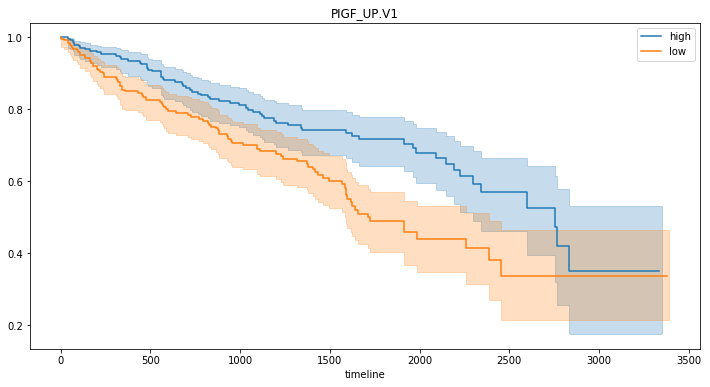

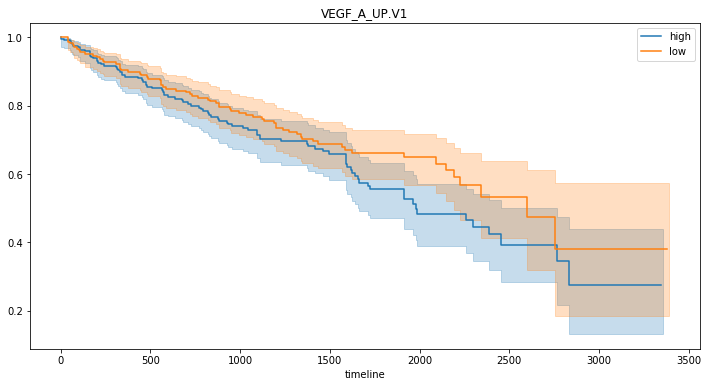

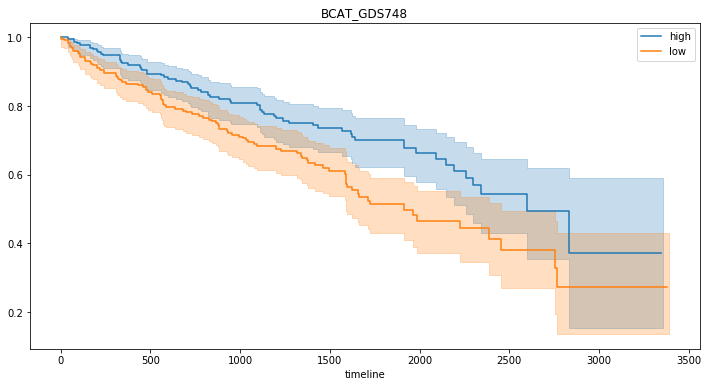

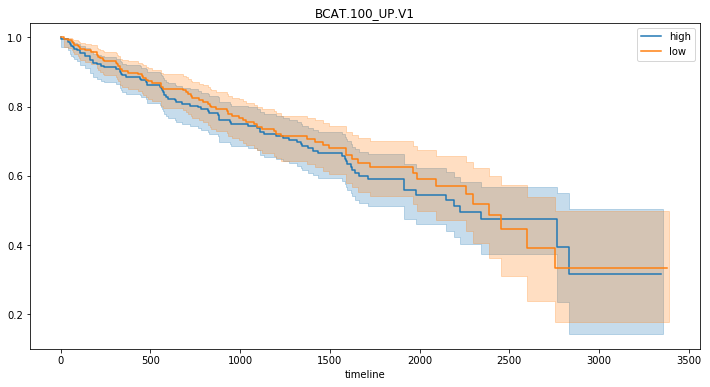

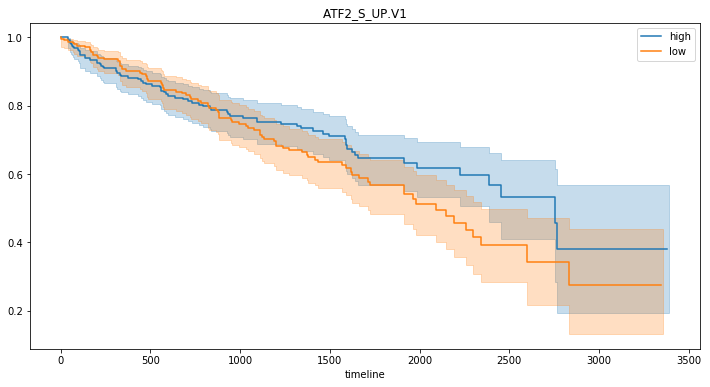

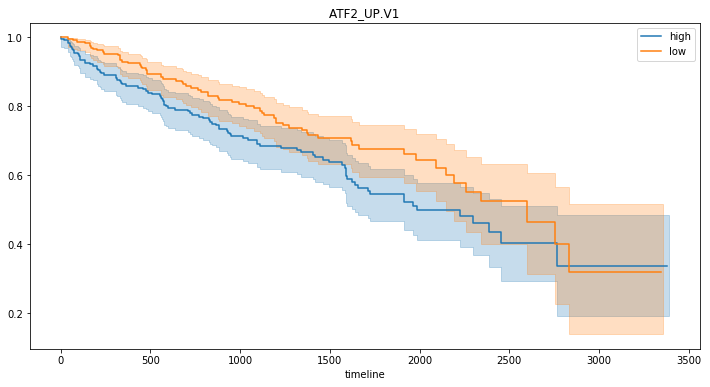

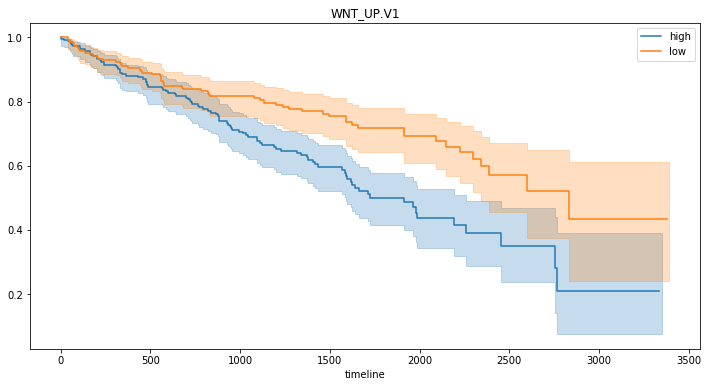

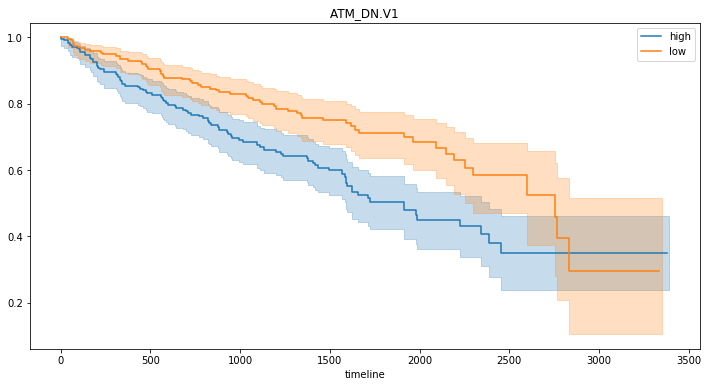

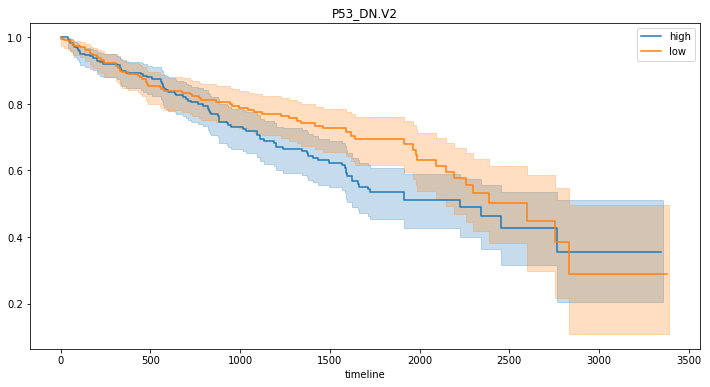

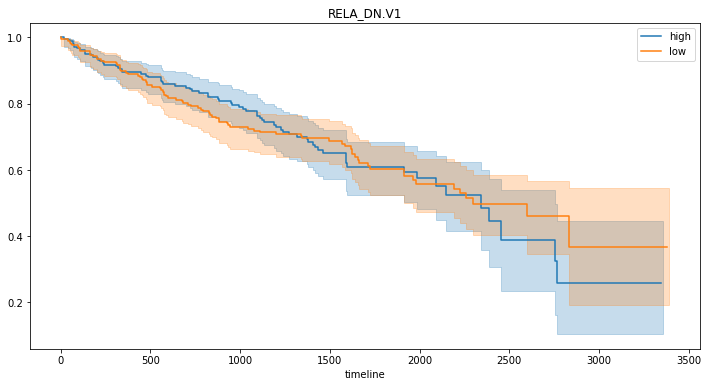

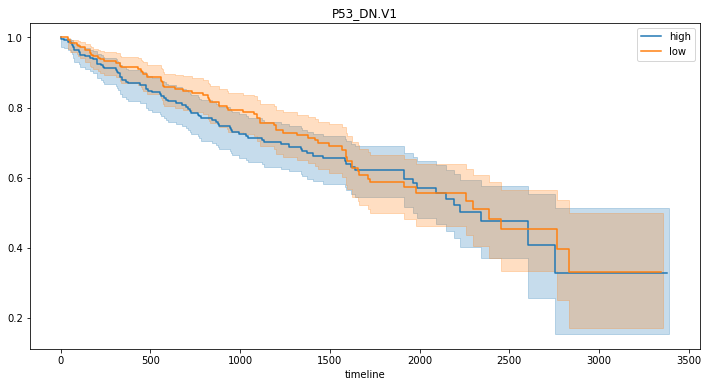

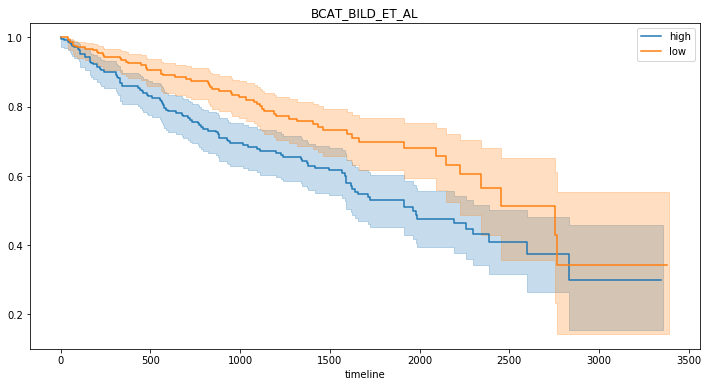

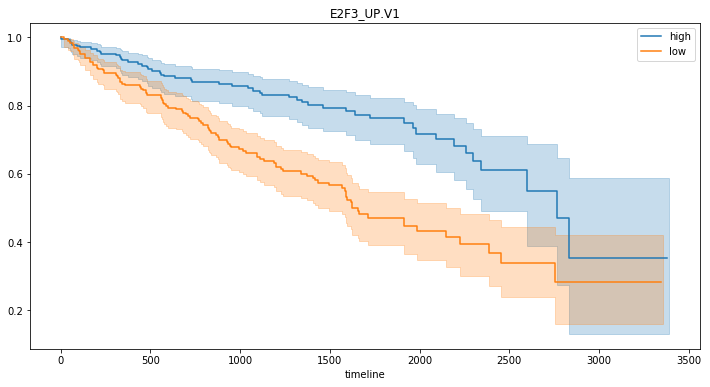

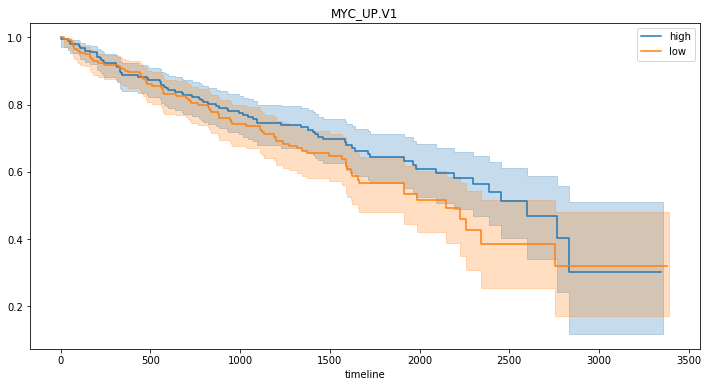

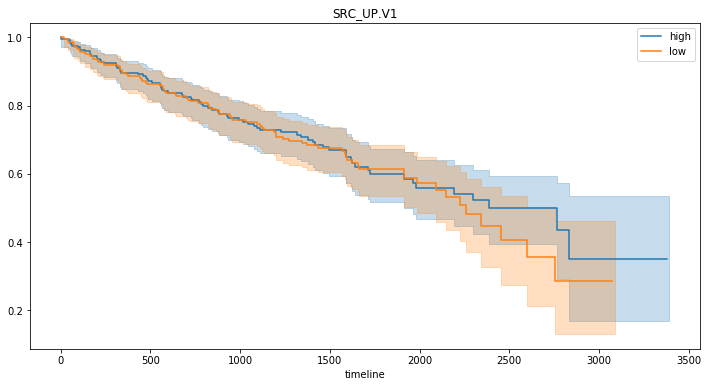

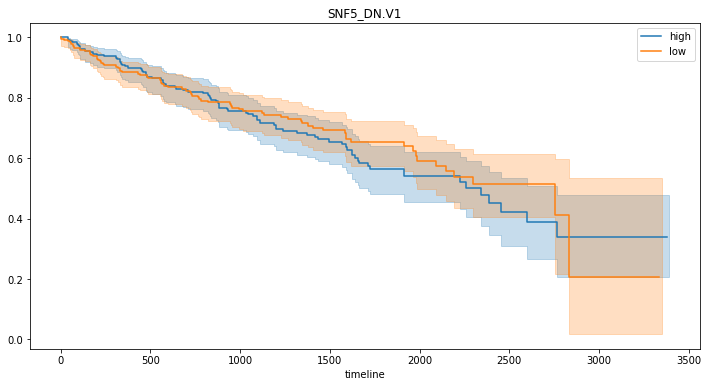

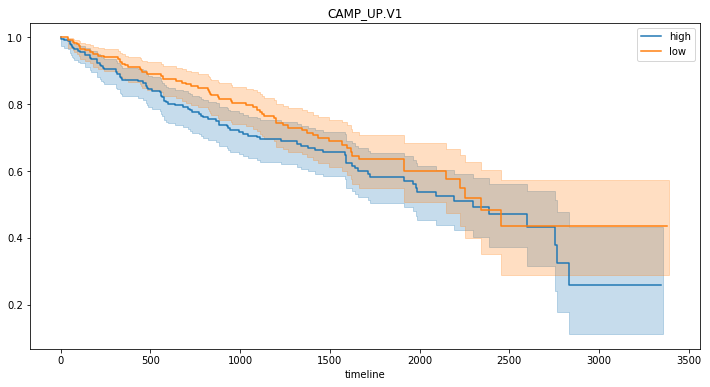

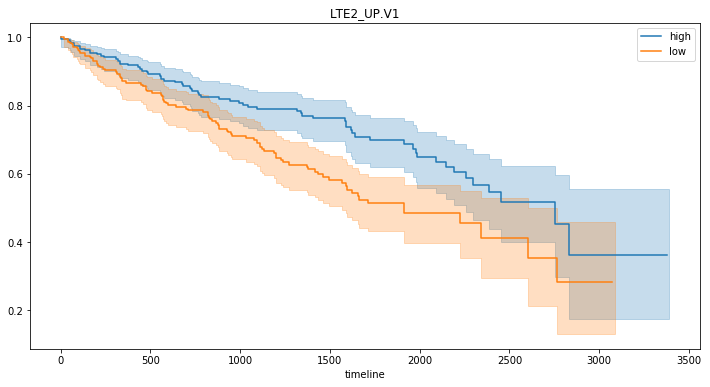

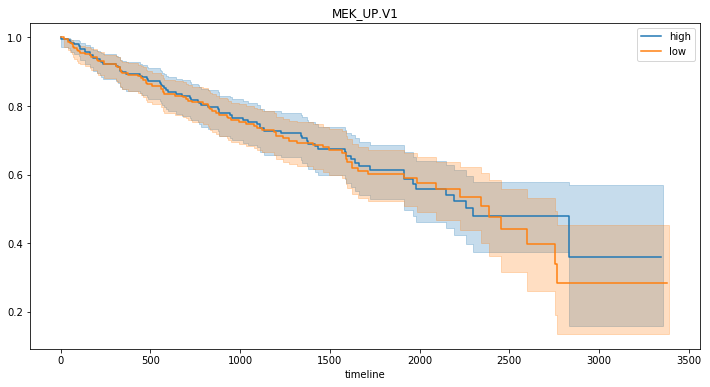

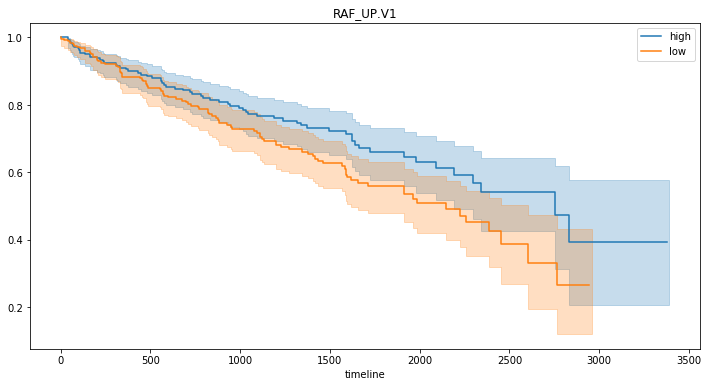

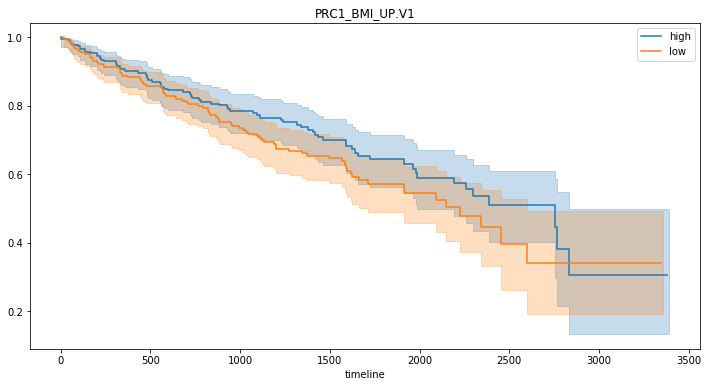

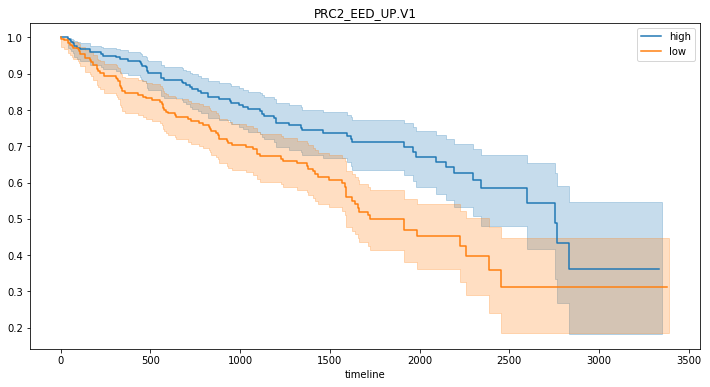

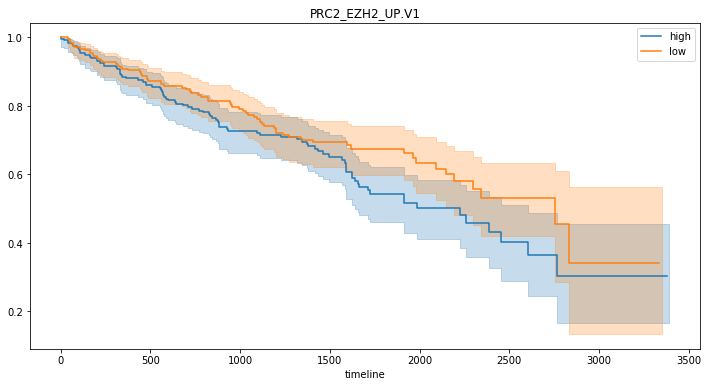

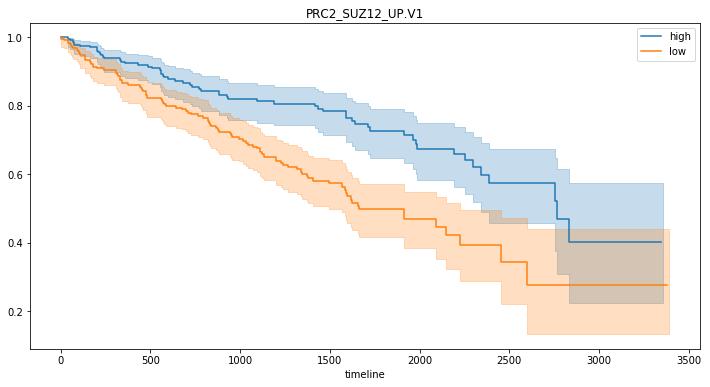

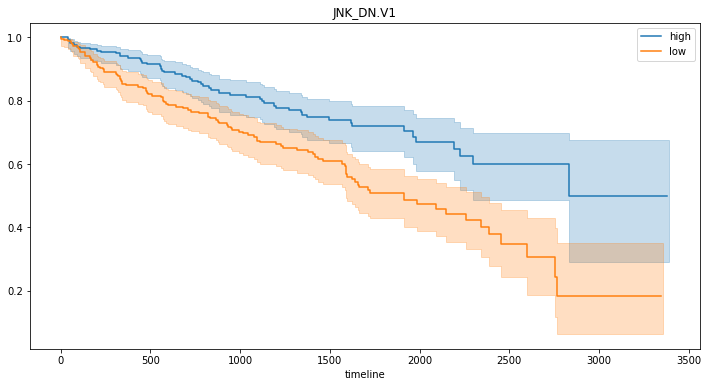

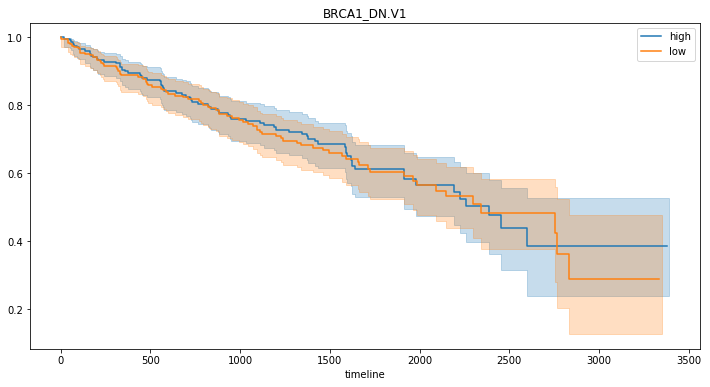

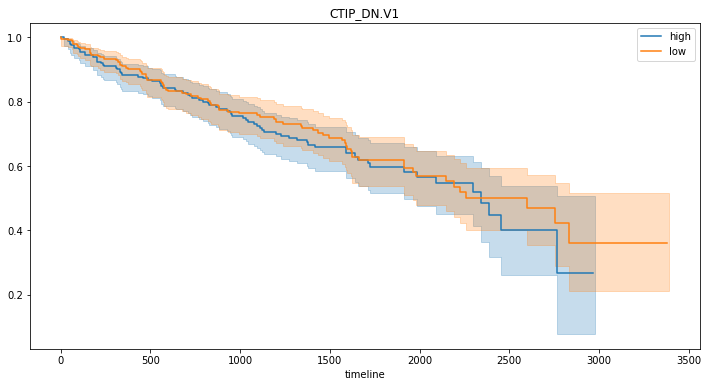

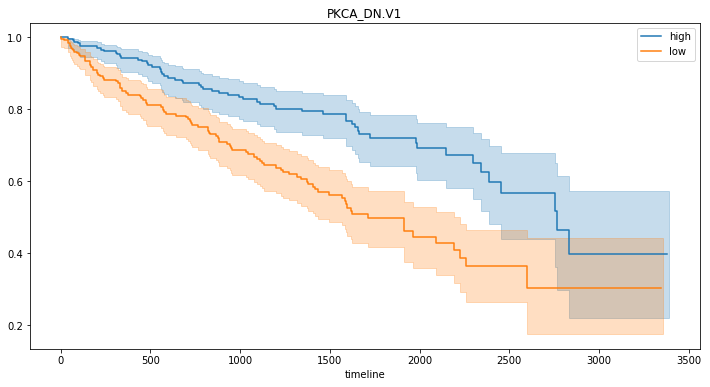

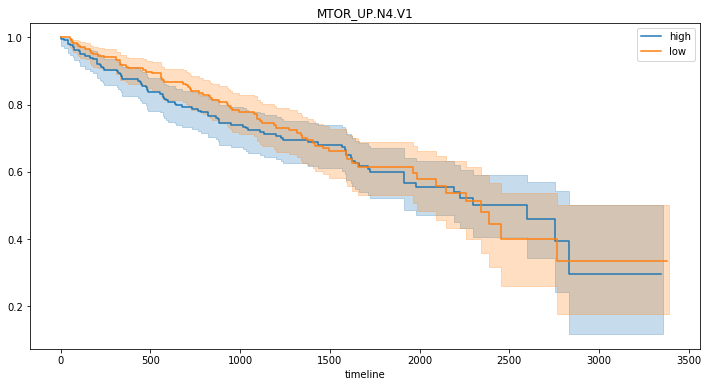

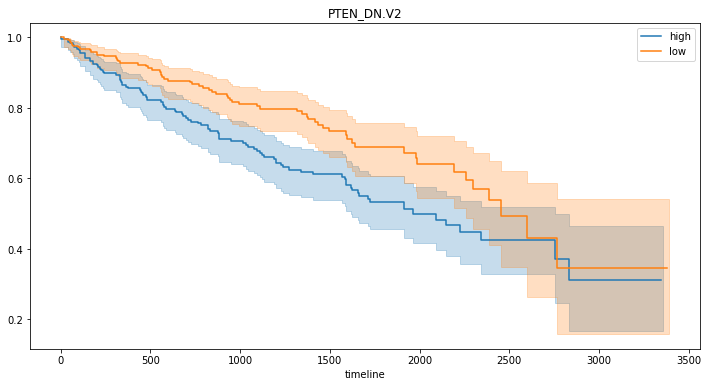

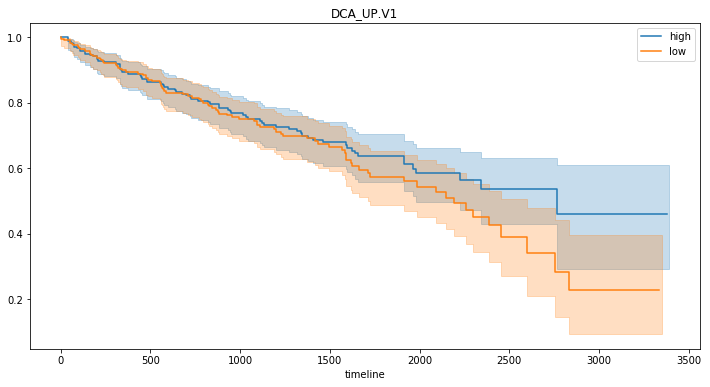

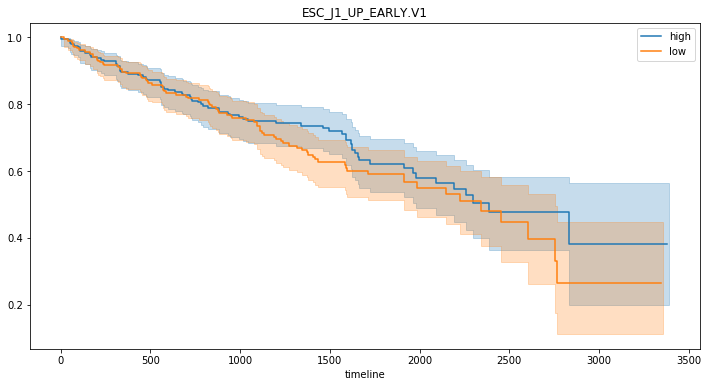

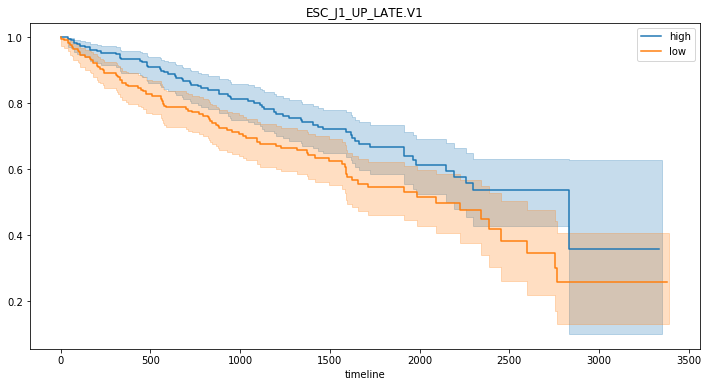

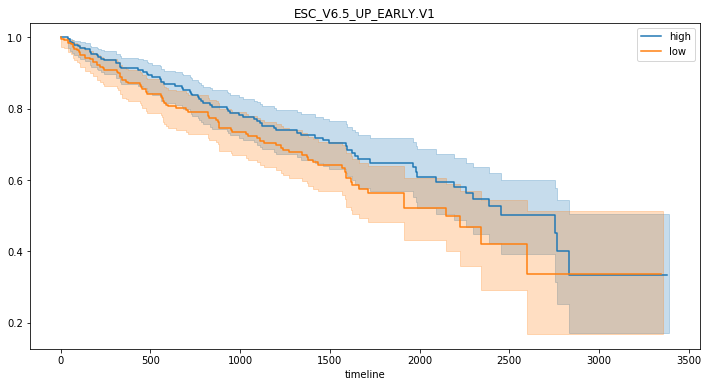

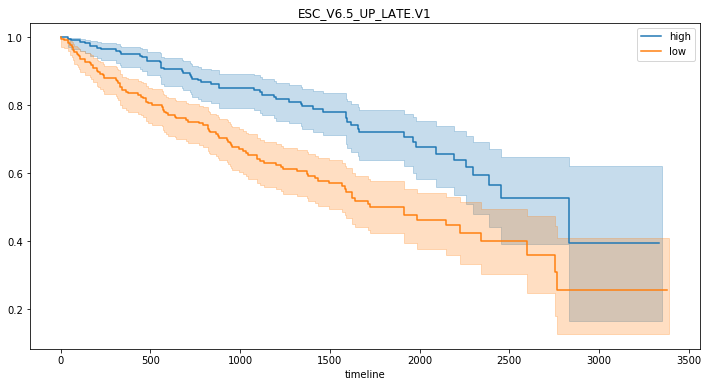

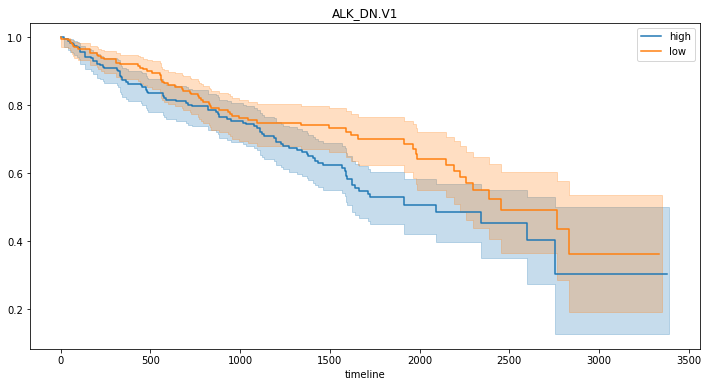

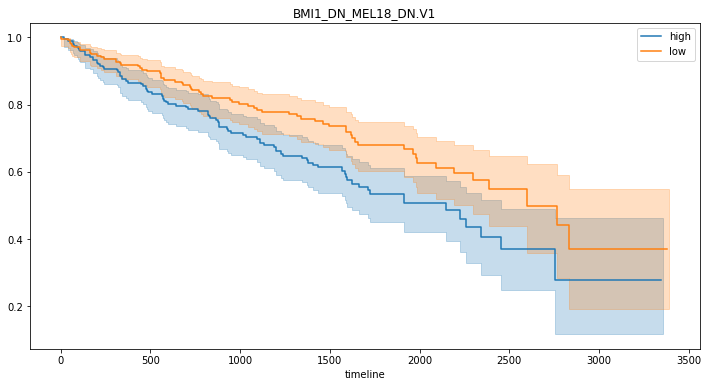

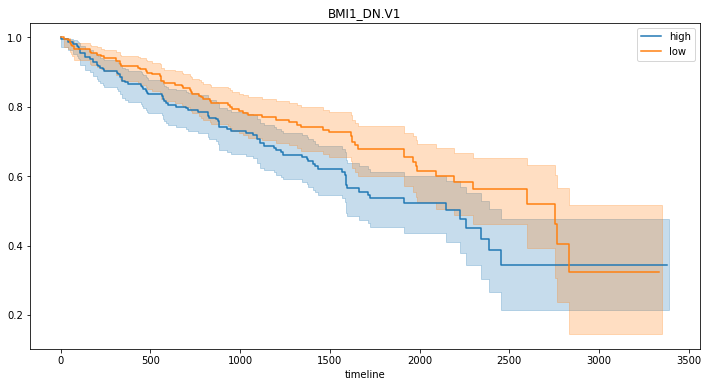

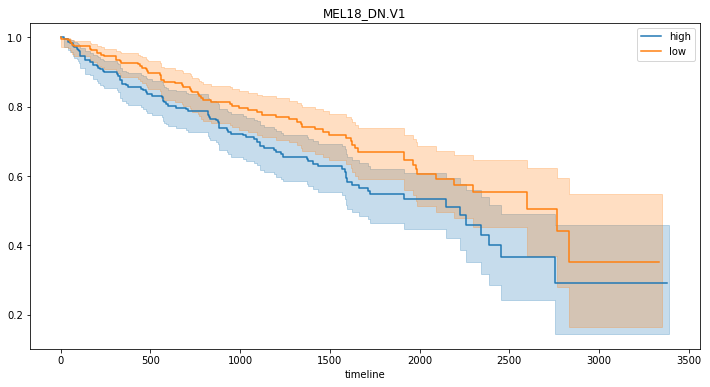

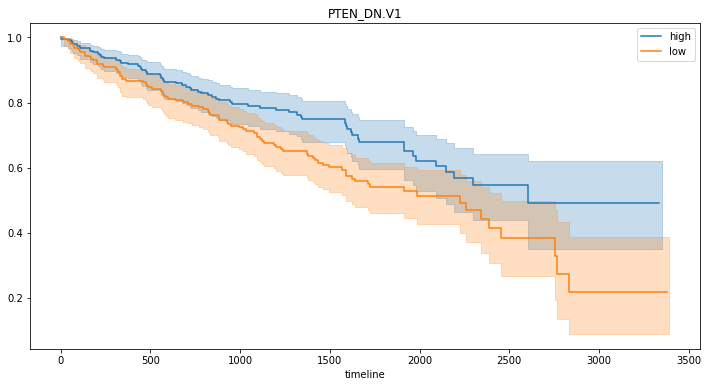

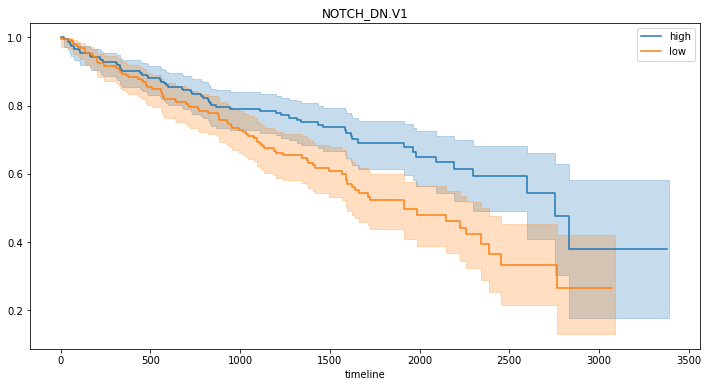

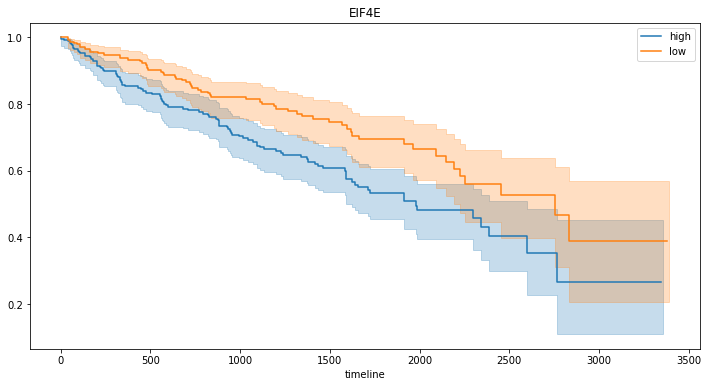

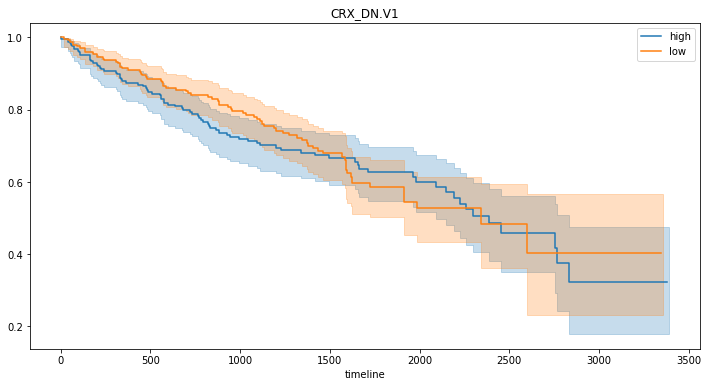

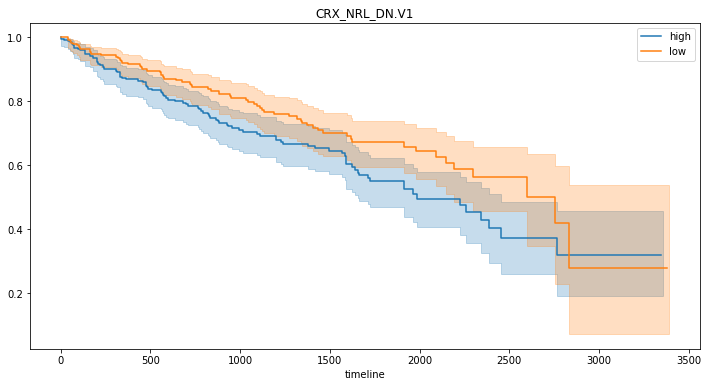

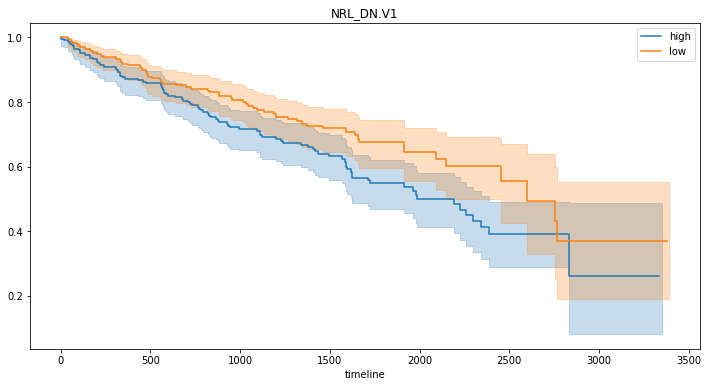

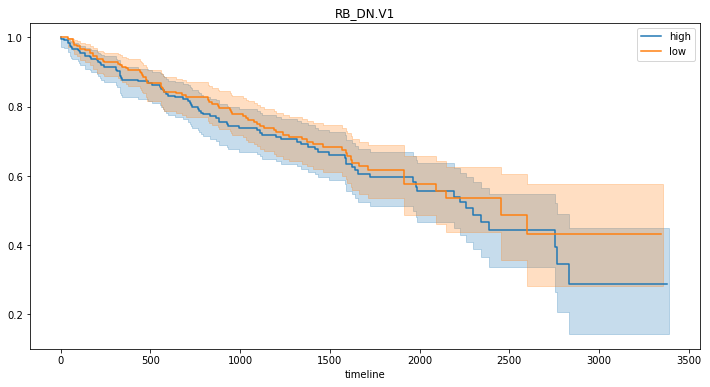

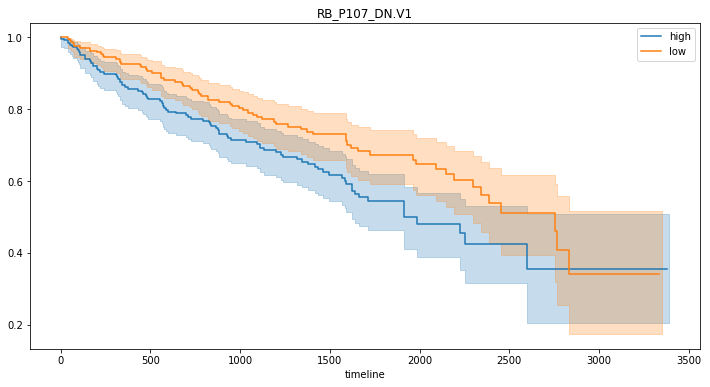

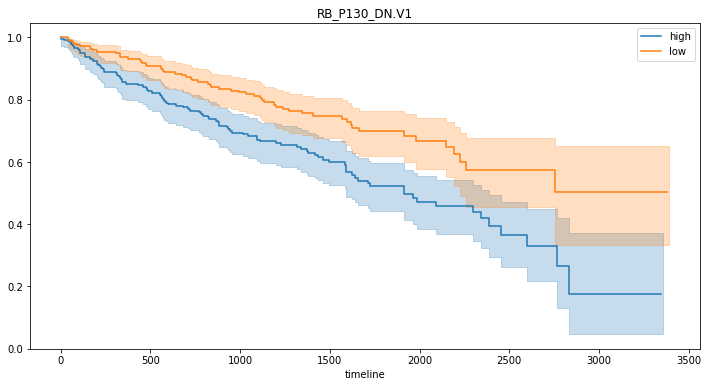

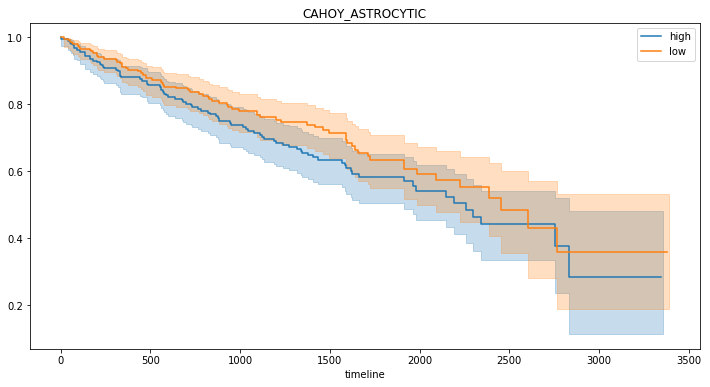

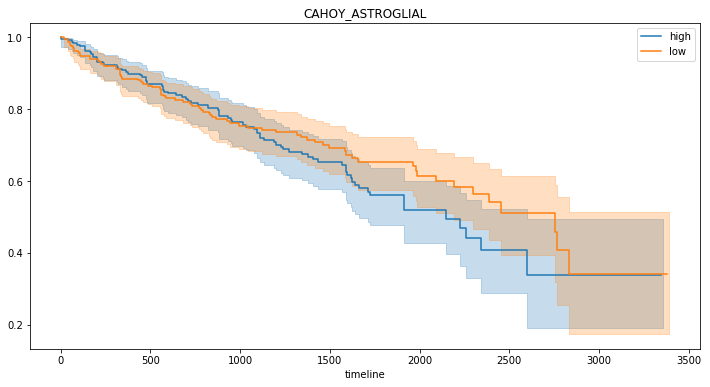

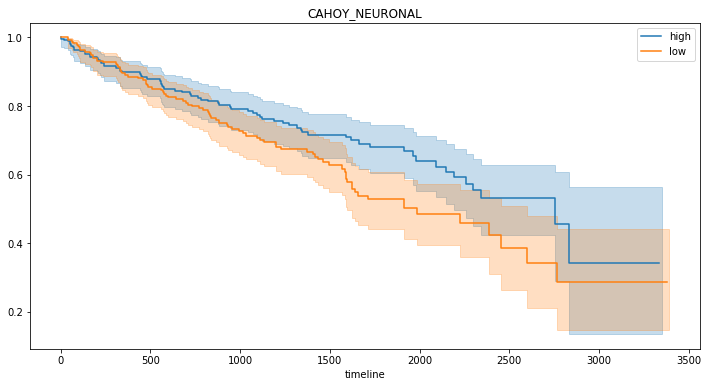

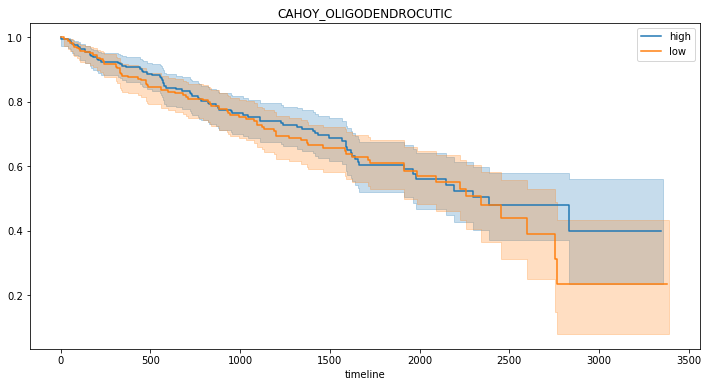

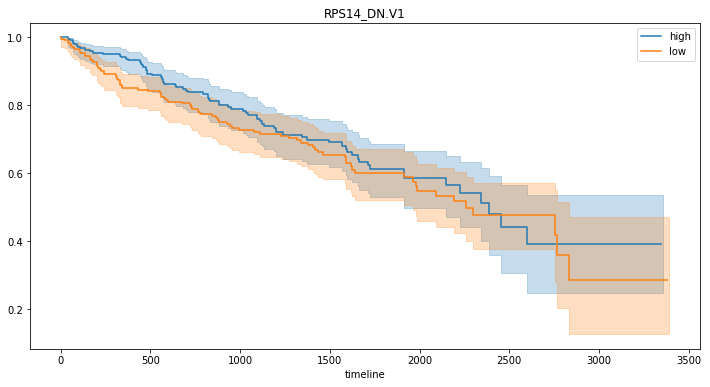

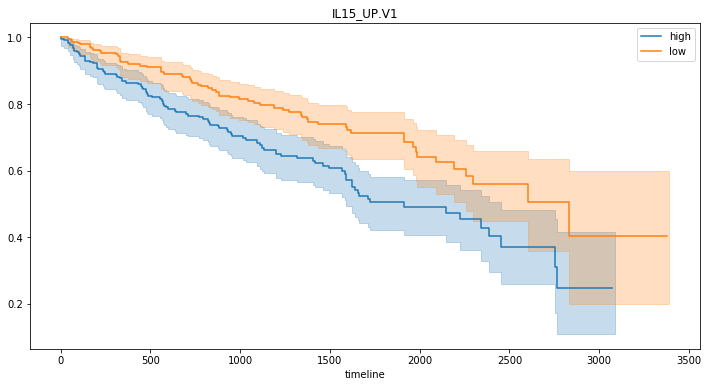

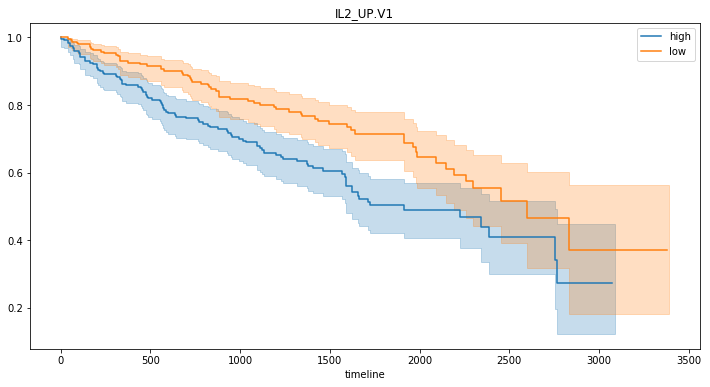

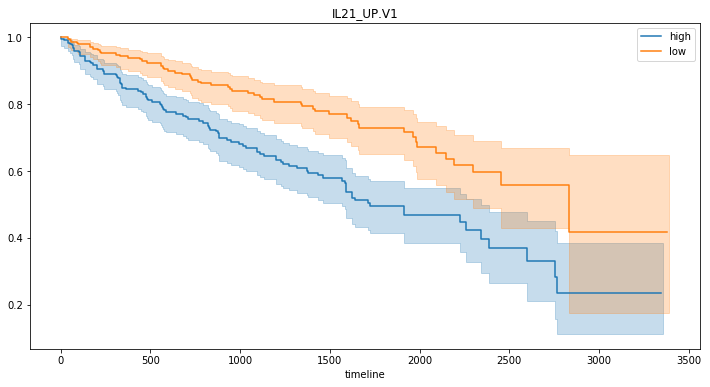

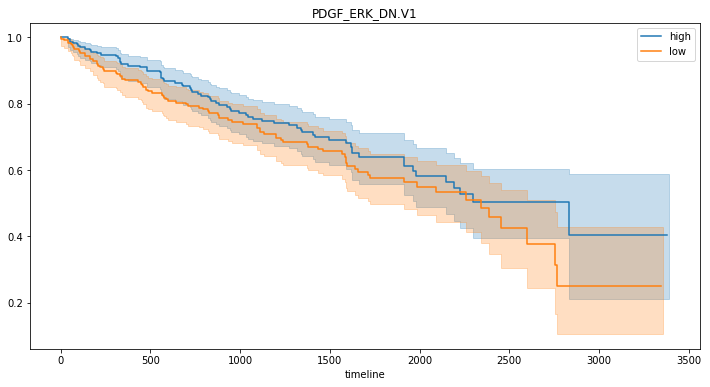

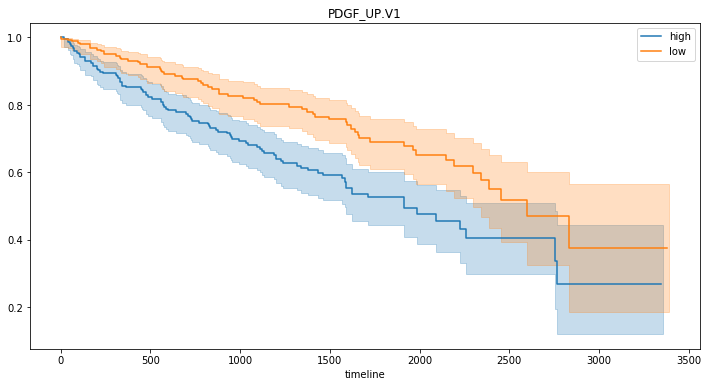

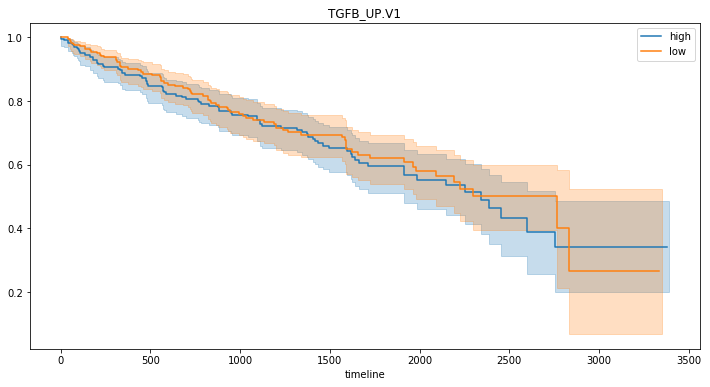

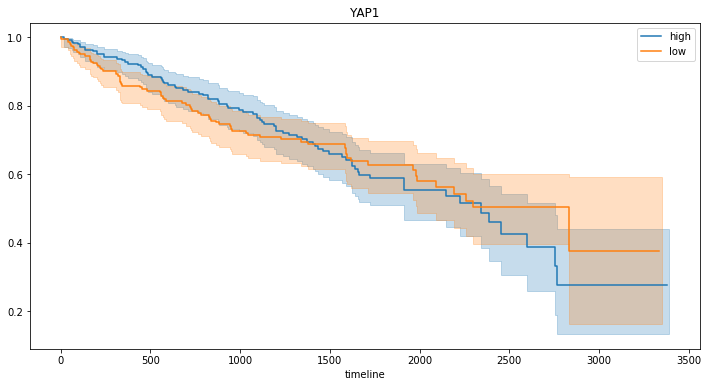

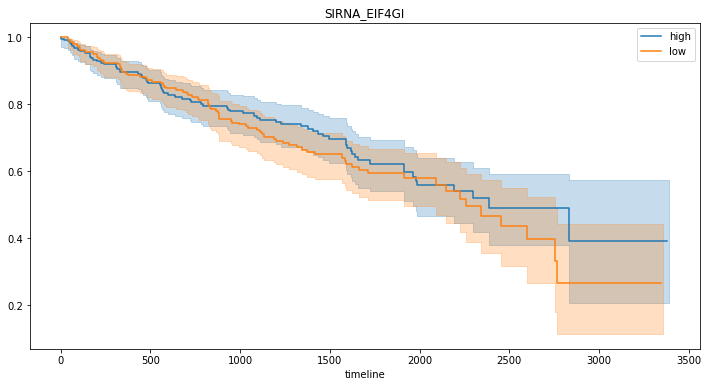

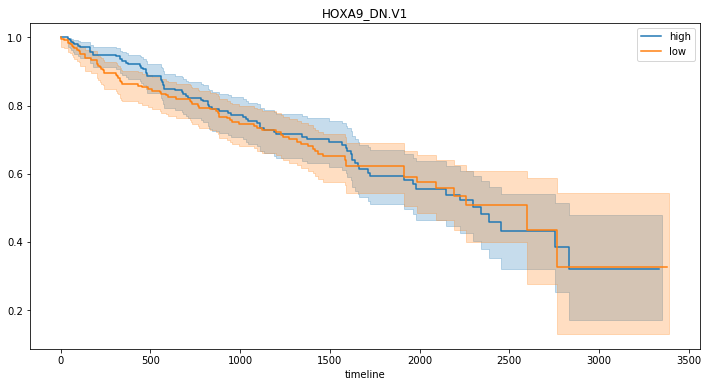

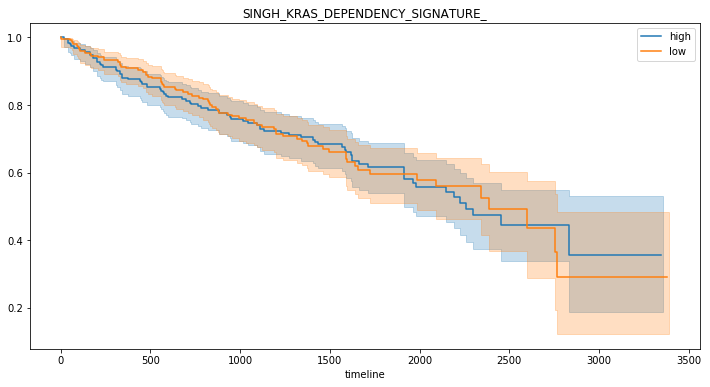

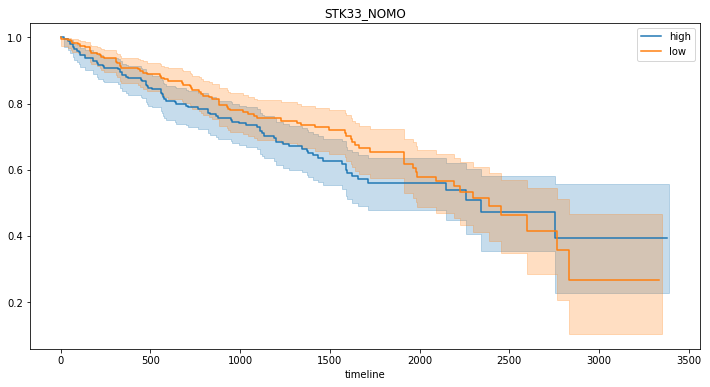

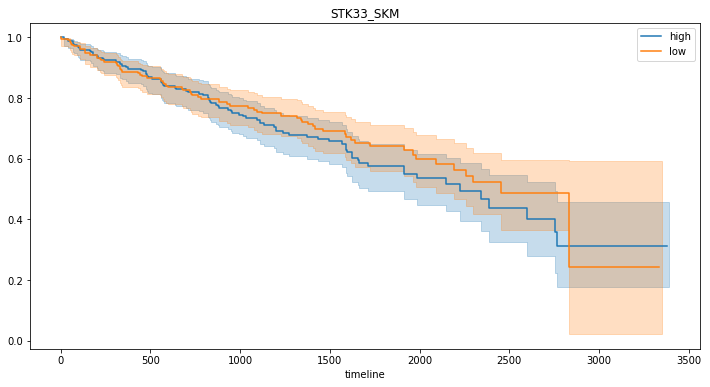

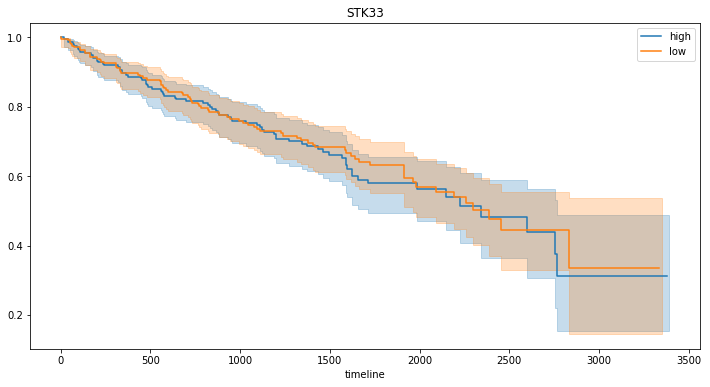

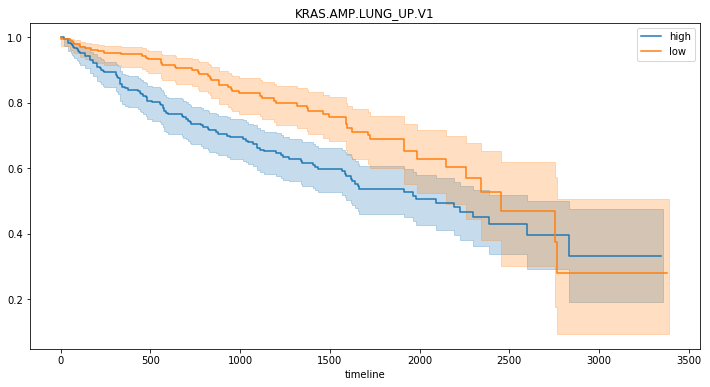

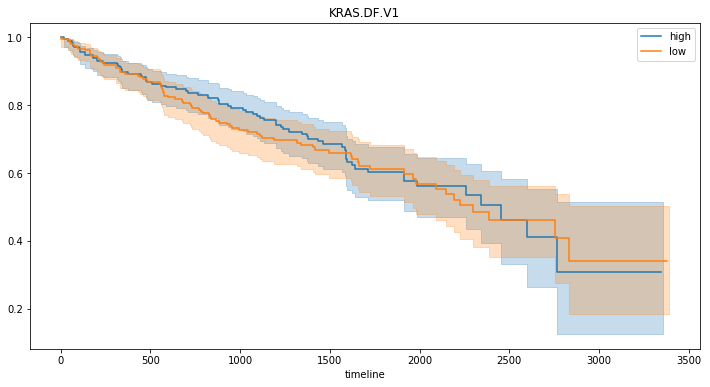

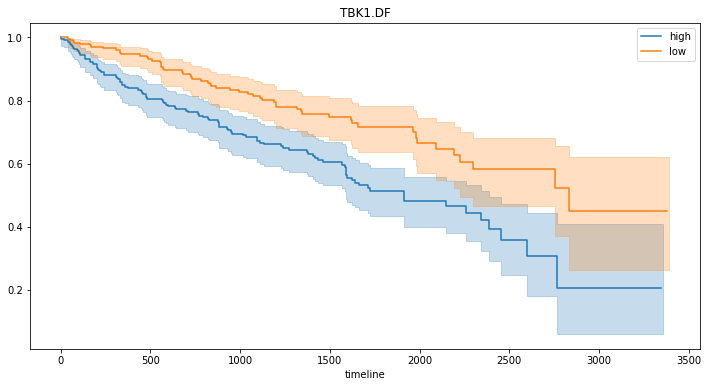

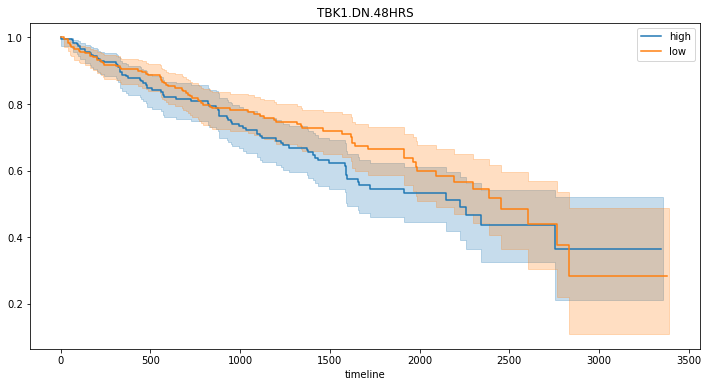

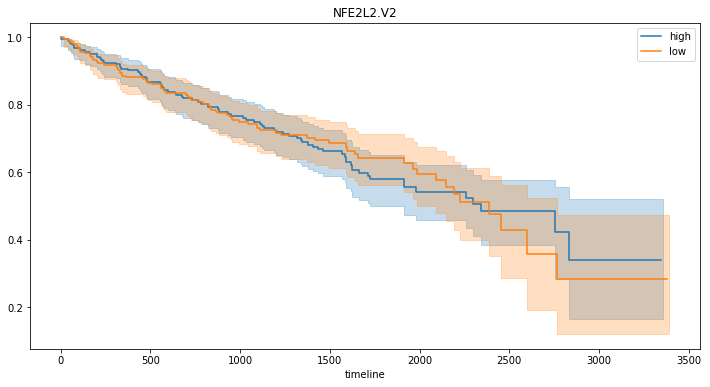

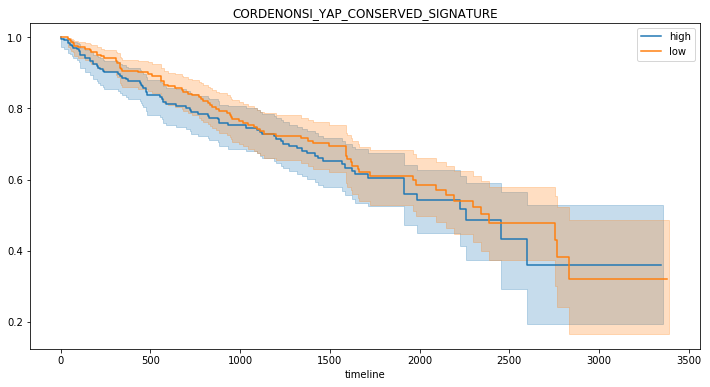

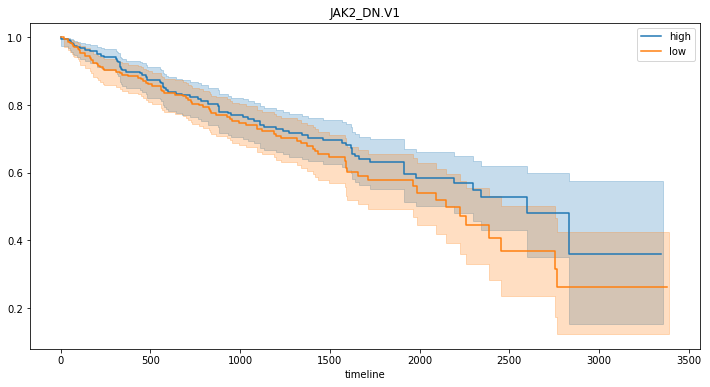

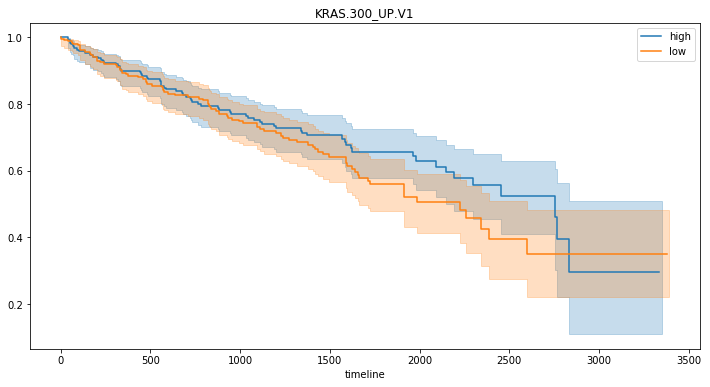

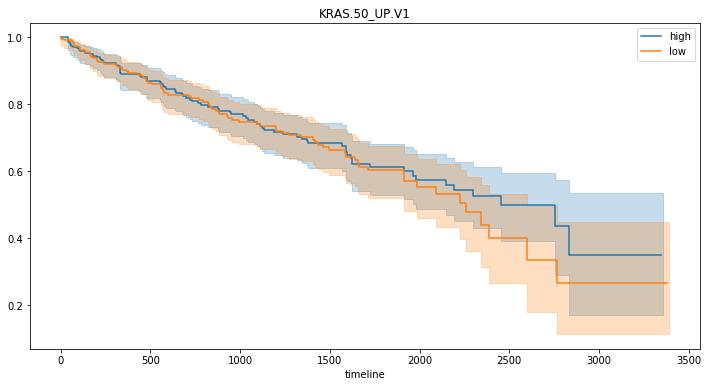

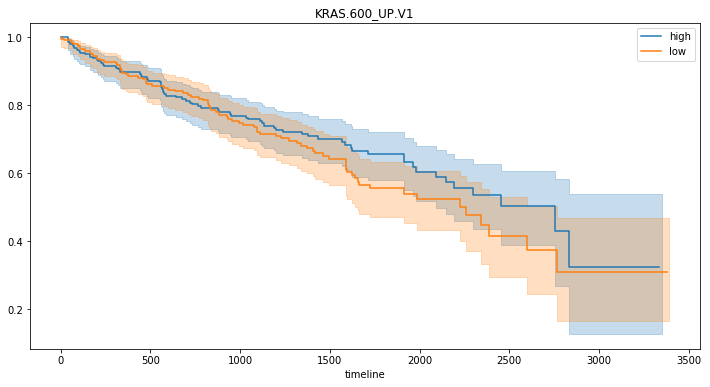

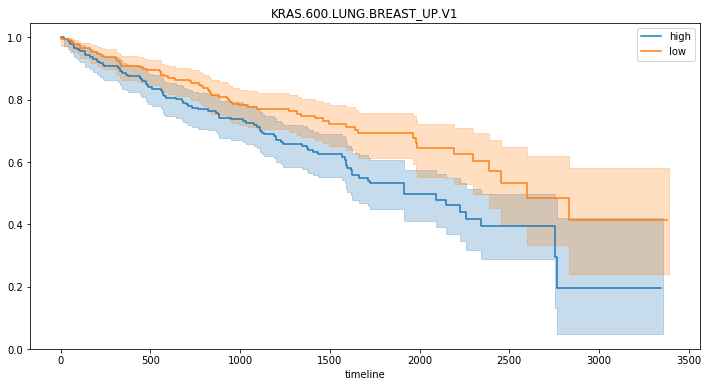

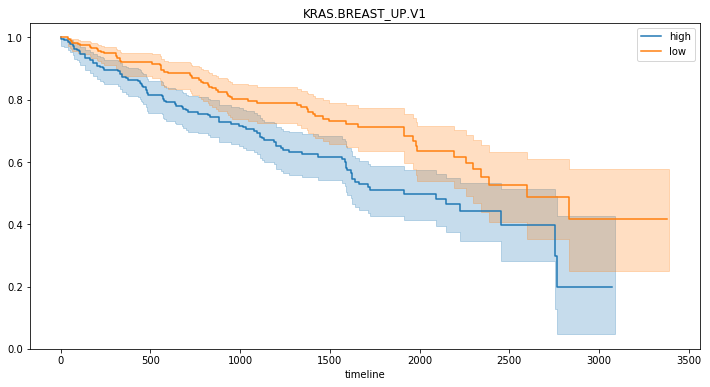

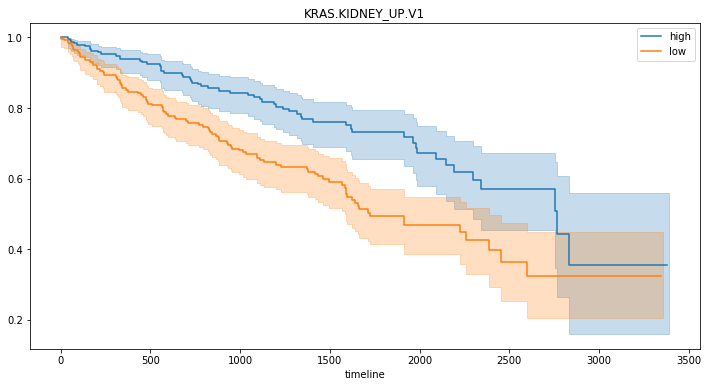

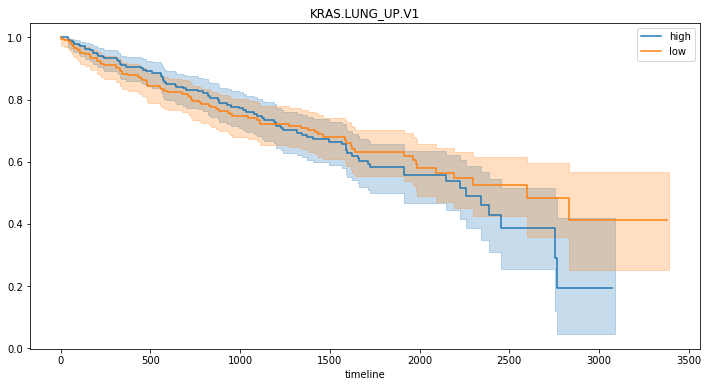

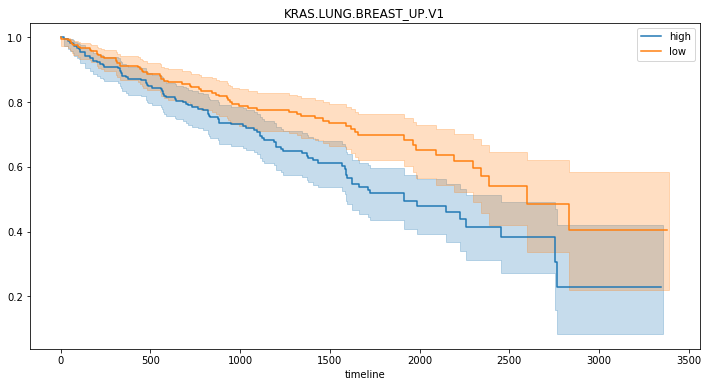

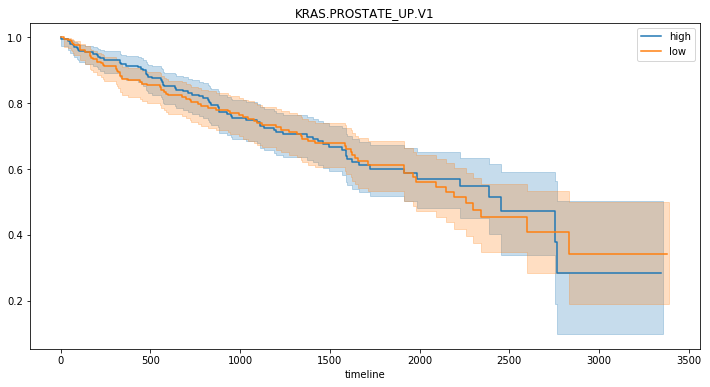

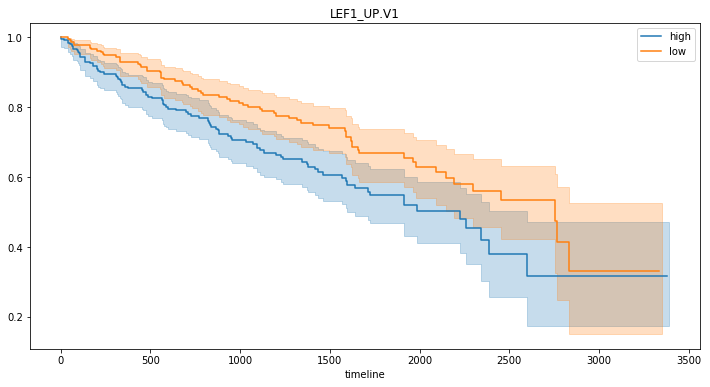

In [155]:
# K-M plots for all gene sets

kmf = lifelines.KaplanMeierFitter()
for i in hl.index:
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    ax.set_title(i)
    high = clinical[h.loc[:,i]]
    T = high['days_to_event']
    E = high['observed']
    kmf.fit(T,event_observed=E,label="high")
    kmf.plot(ax=ax)

    low = clinical[~h.loc[:,i]]
    T = low['days_to_event']
    E = low['observed']
    kmf.fit(T,event_observed=E,label="low")
    kmf.plot(ax=ax)


In [167]:
# Statistical significance of two functions using log rank test
plt.close('all')
ts=[]
pval=[]
sig =[]
for i in hl.index:
    high = clinical[h.loc[:,i]]
    T1 = high['days_to_event']
    E1 = high['observed']
    low = clinical[~h.loc[:,i]]
    T2 = low['days_to_event']
    E2 = low['observed']
    res = lifelines.statistics.logrank_test(T1,T2,E1,E2)
    #print(i)
    pval.append(res.p_value)
    ts.append(res.test_statistic)
    sig.append(res.p_value<0.05/len(hl.index))
    #res.print_summary()
d={
    'nom p':pval,
    #'mult p':list(map(lambda x: x*len(hl.index),pval)),
    'chi-square':ts,
    'significant':sig
}
result = pd.DataFrame(data=d,index=hl.index)
result[result['significant']]


,chi-square,mult p,nom p,significant
Name,,,,
HALLMARK_IL6_JAK_STAT3_SIGNALING,13.905624,0.028257,1.922224e-04,True
HALLMARK_DNA_REPAIR,13.463899,0.035750,2.431978e-04,True
HALLMARK_PANCREAS_BETA_CELLS,14.859588,0.017025,1.158178e-04,True
CYCLIN_D1_KE_.V1,14.218395,0.023927,1.627715e-04,True
WNT_UP.V1,13.014448,0.045437,3.090969e-04,True
E2F3_UP.V1,24.224515,0.000126,8.573404e-07,True
PRC2_EED_UP.V1,12.947631,0.047088,3.203266e-04,True
PRC2_SUZ12_UP.V1,18.639567,0.002321,1.579090e-05,True
JNK_DN.V1,16.101211,0.008827,6.004562e-05,True


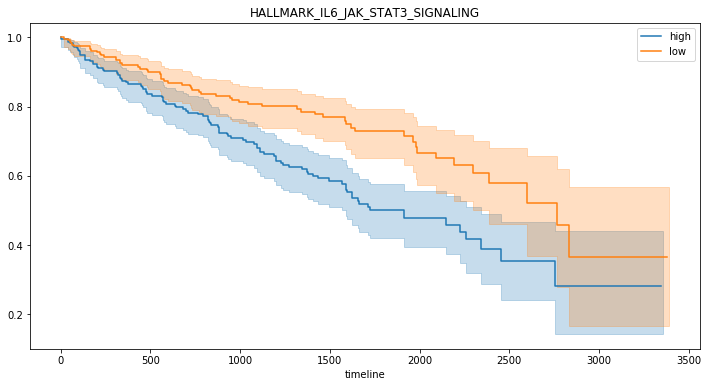

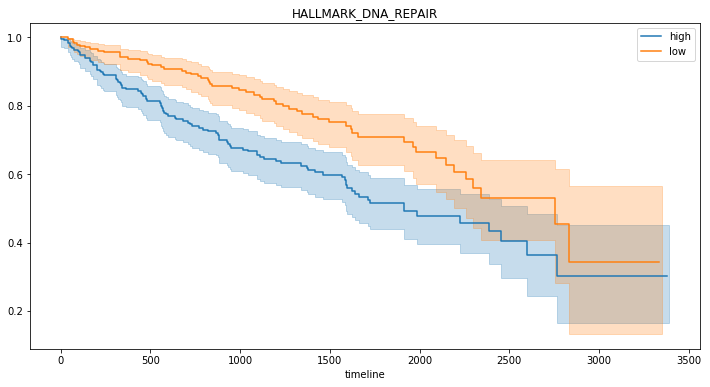

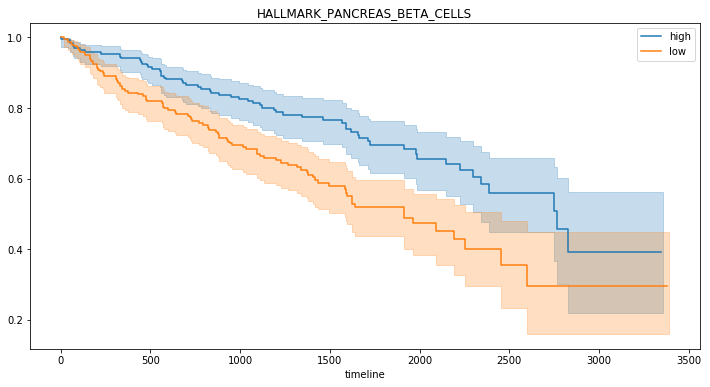

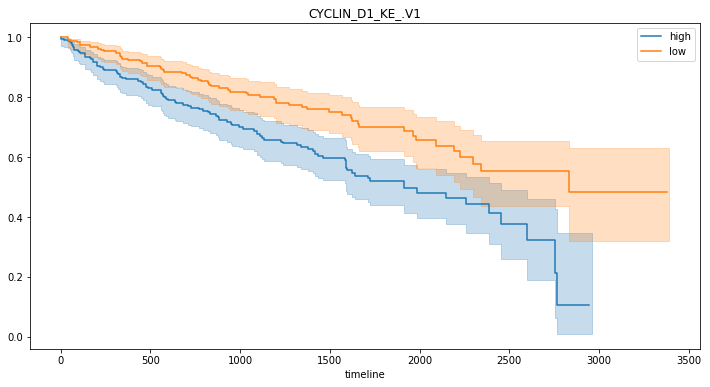

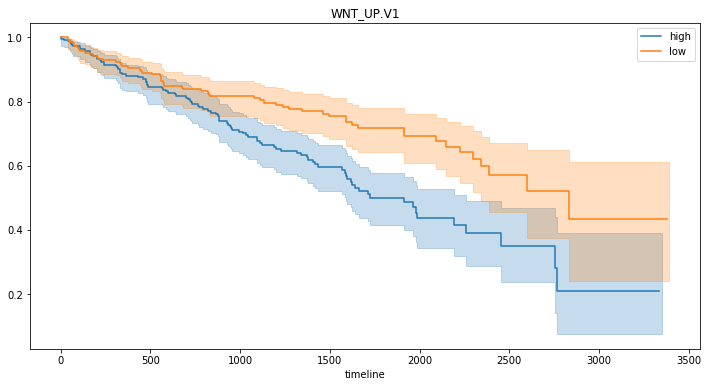

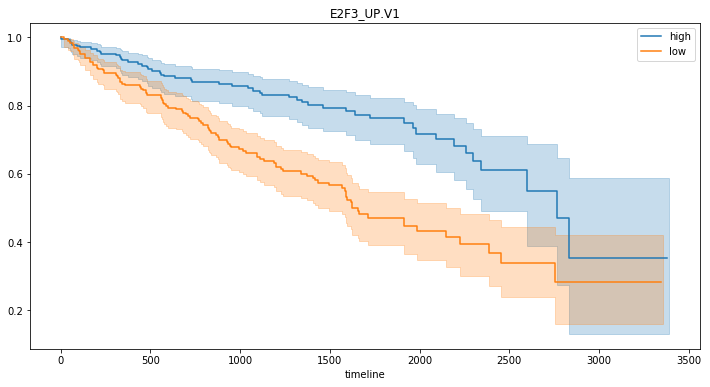

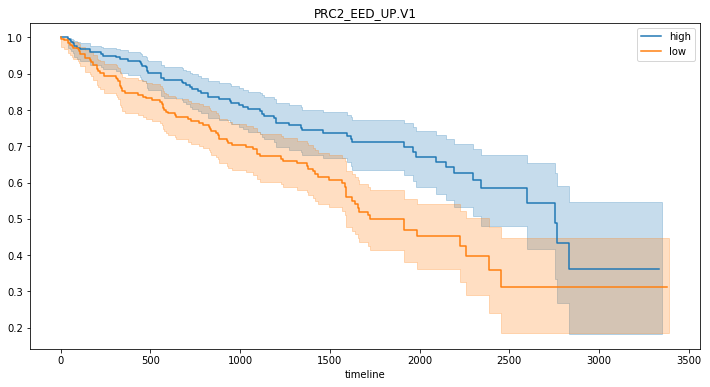

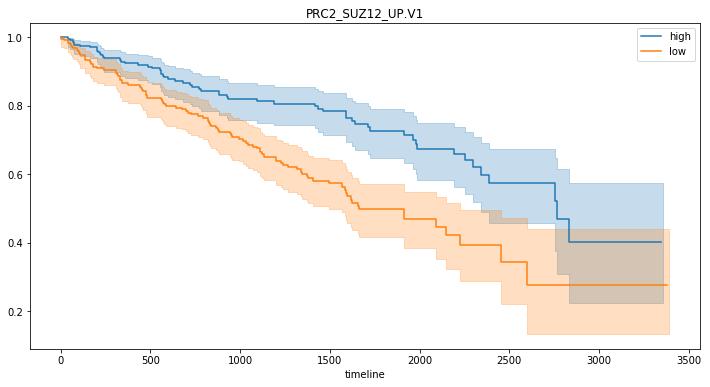

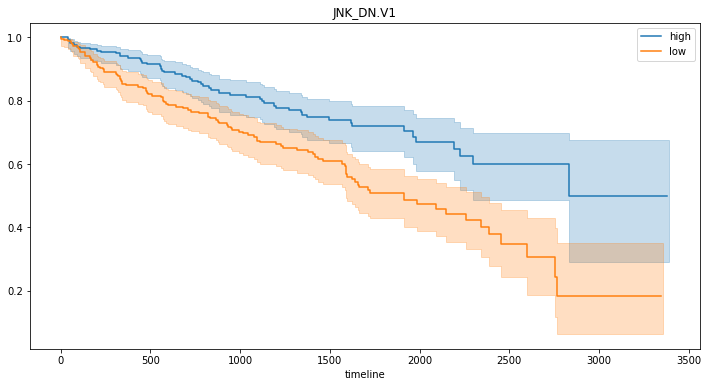

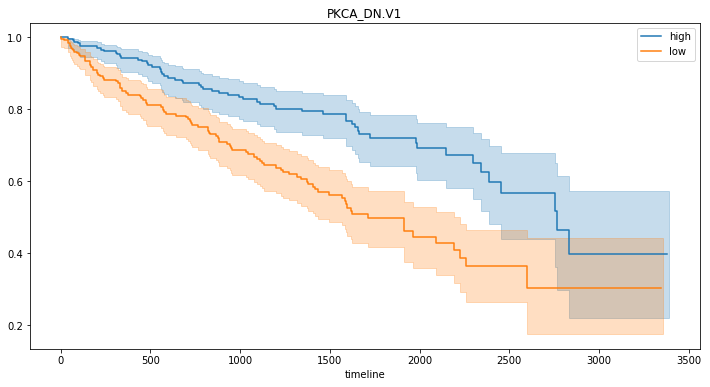

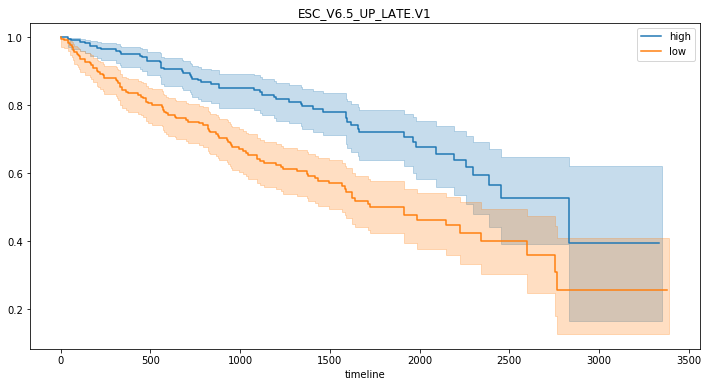

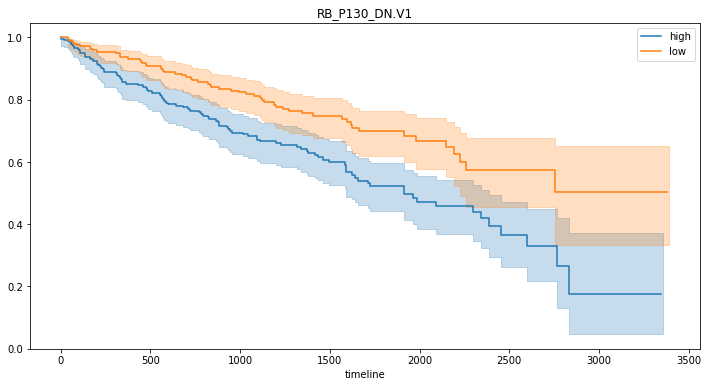

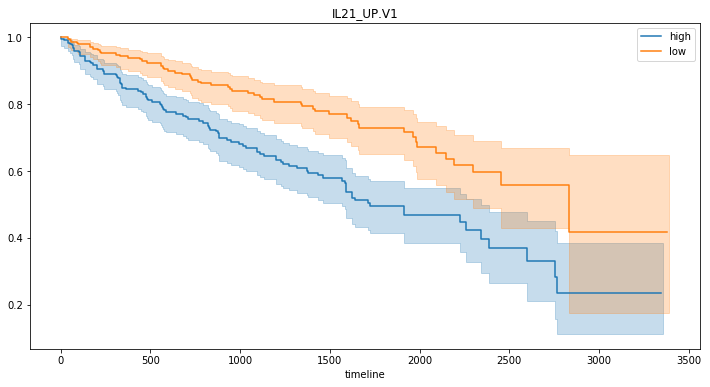

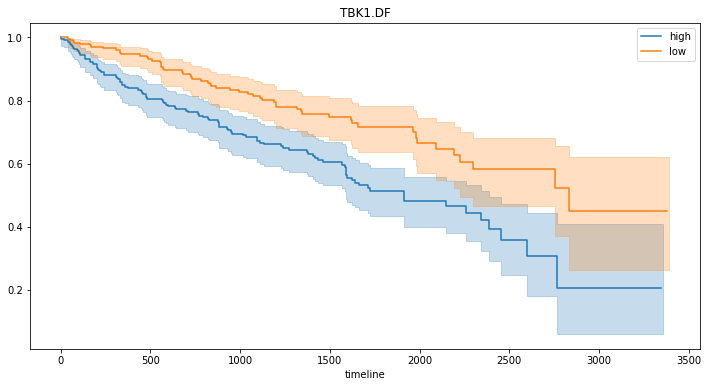

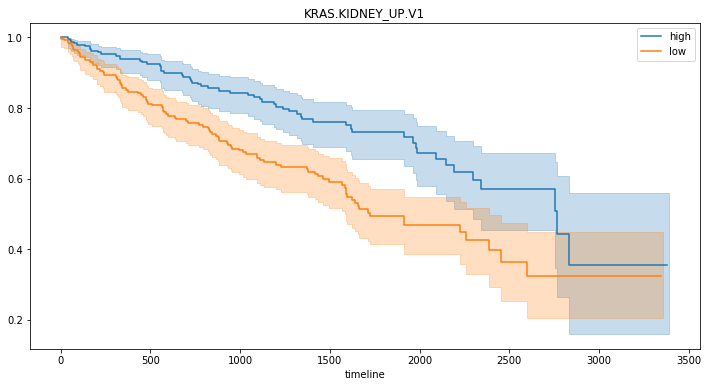

In [157]:
kmf = lifelines.KaplanMeierFitter()
index = result[result['significant']].index
for i in index:
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    ax.set_title(i)
    high = clinical[h.loc[:,i]]
    T = high['days_to_event']
    E = high['observed']
    kmf.fit(T,event_observed=E,label="high")
    kmf.plot(ax=ax)

    low = clinical[~h.loc[:,i]]
    T = low['days_to_event']
    E = low['observed']
    kmf.fit(T,event_observed=E,label="low")
    kmf.plot(ax=ax)

In [158]:
for c in h.columns:
    h[c]=pd.get_dummies(h[c])[True]

n=532, number of events=160

                                              coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
HALLMARK_TNFA_SIGNALING_VIA_NFKB            0.9829     2.6722    0.4530  2.1699 0.0300      0.0951      1.8707    *
HALLMARK_HYPOXIA                            0.0782     1.0814    0.4455  0.1756 0.8606     -0.7950      0.9515     
HALLMARK_CHOLESTEROL_HOMEOSTASIS           -0.3221     0.7246    0.3144 -1.0244 0.3056     -0.9384      0.2942     
HALLMARK_MITOTIC_SPINDLE                   -0.0972     0.9074    0.4578 -0.2123 0.8319     -0.9946      0.8002     
HALLMARK_WNT_BETA_CATENIN_SIGNALING         0.0054     1.0055    0.4374  0.0124 0.9901     -0.8518      0.8627     
HALLMARK_TGF_BETA_SIGNALING                -0.5086     0.6013    0.4054 -1.2545 0.2097     -1.3032      0.2860     
HALLMARK_IL6_JAK_STAT3_SIGNALING            0.6189     1.8569    0.5507  1.1239 0.2610     -0.4604      1.6982     
HALLMARK_DNA_REPAIR                        

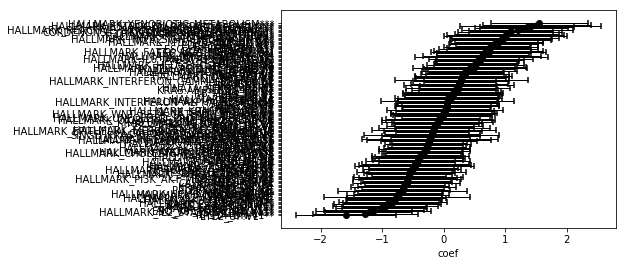

In [159]:
base=clinical[['days_to_event','observed']]
set_hazard_df=base.join(h)
cph = lifelines.CoxPHFitter()
cph.fit(set_hazard_df,duration_col='days_to_event',event_col='observed',step_size=.1)
cph.print_summary()
cph.plot()

n=532, number of events=160

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
HALLMARK_IL6_JAK_STAT3_SIGNALING  0.2952     1.3434    0.2049  1.4405 0.1497     -0.1064      0.6969   
HALLMARK_DNA_REPAIR               0.1014     1.1067    0.2066  0.4905 0.6237     -0.3036      0.5063   
HALLMARK_PANCREAS_BETA_CELLS     -0.0661     0.9361    0.1980 -0.3336 0.7387     -0.4542      0.3221   
CYCLIN_D1_KE_.V1                  0.0952     1.0999    0.2188  0.4350 0.6636     -0.3337      0.5240   
WNT_UP.V1                         0.2585     1.2949    0.1855  1.3933 0.1635     -0.1051      0.6221   
E2F3_UP.V1                       -0.3731     0.6886    0.2017 -1.8498 0.0643     -0.7685      0.0222  .
PRC2_EED_UP.V1                   -0.0828     0.9205    0.2053 -0.4034 0.6867     -0.4852      0.3196   
PRC2_SUZ12_UP.V1                 -0.4580     0.6325    0.1885 -2.4301 0.0151     -0.8274     -0.0886  *
JNK_DN.V1                        -0

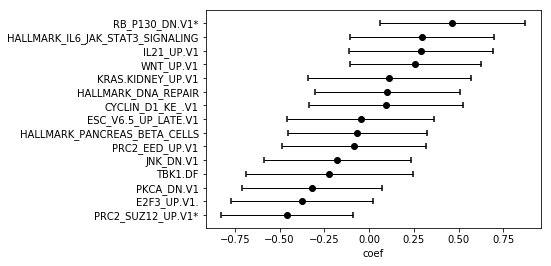

In [160]:
set_hazard_df=base.join(h[result[result['significant']].index])
cph = lifelines.CoxPHFitter()
cph.fit(set_hazard_df,duration_col='days_to_event',event_col='observed')
cph.print_summary()
cph.plot()
hr=np.exp(cph.hazards_.loc['coef'])

In [161]:
hr

HALLMARK_IL6_JAK_STAT3_SIGNALING    1.343409
HALLMARK_DNA_REPAIR                 1.106674
HALLMARK_PANCREAS_BETA_CELLS        0.936075
CYCLIN_D1_KE_.V1                    1.099858
WNT_UP.V1                           1.294949
E2F3_UP.V1                          0.688581
PRC2_EED_UP.V1                      0.920518
PRC2_SUZ12_UP.V1                    0.632532
JNK_DN.V1                           0.837227
PKCA_DN.V1                          0.726864
ESC_V6.5_UP_LATE.V1                 0.953973
RB_P130_DN.V1                       1.591867
IL21_UP.V1                          1.335146
TBK1.DF                             0.800702
KRAS.KIDNEY_UP.V1                   1.119208
Name: coef, dtype: float64

In [168]:
'''
Significant gene set hits:
HALLMARK_IL6_JAK_STAT3_SIGNALING
HALLMARK_DNA_REPAIR
HALLMARK_PANCREAS_BETA_CELLS
CYCLIN_D1_KE_.V1
WNT_UP.V1
E2F3_UP.V1
PRC2_EED_UP.V1
PRC2_SUZ12_UP.V1
JNK_DN.V1
PKCA_DN.V1
ESC_V6.5_UP_LATE.V1
RB_P130_DN.V1
IL21_UP.V1
TBK1.DF
KRAS.KIDNEY_UP.V1
'''
hypotheses = ['IL6','JAK2','STAT3','CCND1','WNT1','WNT2','E2F3','EED','SUZ12','MAPK8','PRKCA','RB1','RBL2','IL21','TBK1','KRAS']

In [169]:
rna_hyp

,tcga-3z-a93z,tcga-6d-aa2e,tcga-a3-3306,tcga-a3-3307,tcga-a3-3308,tcga-a3-3311,tcga-a3-3313,tcga-a3-3316,tcga-a3-3317,tcga-a3-3319,...,tcga-g6-a5pc,tcga-g6-a8l6,tcga-g6-a8l7,tcga-g6-a8l8,tcga-gk-a6c7,tcga-mm-a563,tcga-mm-a564,tcga-mm-a84u,tcga-mw-a4ec,tcga-t7-a92i
Hybridization REF,,,,,,,,,,,,,,,,,,,,,
IL6,9.4094,30.7609,4.6584,2.7523,169.2488,86.3765,9.8459,307.4830,7.3746,126.8811,...,6.6140,56.8883,1765.7841,6.0184,4.1653,19.0955,48.3972,54.6479,4.5105,2.6922
STAT3,3317.7555,2753.3729,4150.1035,5267.4312,6703.0623,6182.7580,3857.0878,5130.6122,5179.5723,6836.6462,...,2940.2903,3202.1933,5021.3849,3548.5495,5606.8568,3853.7688,3059.0823,4522.2535,3633.4188,4305.1152
CCND1,36263.0430,12715.2671,19696.6874,22479.6835,12284.6106,13913.5968,3642.1418,9372.7891,28517.2603,19258.1424,...,28000.4924,11533.1666,15625.6925,30478.6560,35001.5572,16796.9899,5780.7165,17593.1211,34789.5397,8836.7724
WNT1,0.6273,2.6983,1.0352,1.3761,0.9175,2.0010,1.9260,2.7211,1.4749,2.1684,...,4.4093,0.6854,3.0550,0.9259,0.9612,2.0101,4.3997,2.8169,1.2301,2.9913
WNT2,2.5092,9.7140,3.1056,0.4587,4.1289,0.3335,2.6965,97.2789,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0050,0.0000,4.5070,0.0000,2.3931
E2F3,187.5608,318.4026,267.5983,363.3028,485.3768,541.6041,387.1341,482.3129,443.5841,330.3216,...,352.7466,254.9692,328.9206,366.1973,415.2515,246.2312,348.2087,451.2676,265.2998,460.0658
EED,250.9174,241.7701,339.5445,233.0275,249.1111,265.1326,288.1356,249.6599,275.0737,255.8728,...,325.5558,305.0034,418.5336,313.4205,245.1137,287.4372,370.8360,277.7465,247.2578,281.7828
SUZ12,531.9449,863.4647,838.5093,758.2569,913.8663,772.0527,2344.3760,850.3401,911.8732,632.0925,...,288.0764,513.3653,766.8024,556.0089,746.5556,716.0804,547.4544,484.5070,688.4675,1207.2988
MAPK8,151.1777,226.1198,312.6294,311.0092,238.5595,301.8176,353.6210,187.0748,291.6667,191.9046,...,16.1676,82.9335,15.2749,129.1644,288.3691,150.2513,88.6235,85.6338,282.1117,251.8696


/home/chapmano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/chapmano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,chi-square,nom p,significant
Hybridization REF,,,
IL6,26.046375,3.333142e-07,True
JAK2,0.060201,8.061791e-01,False
STAT3,7.198851,7.295027e-03,False
CCND1,9.456329,2.104218e-03,True
WNT1,3.480951,6.207907e-02,False
WNT2,3.991221,4.573792e-02,False
E2F3,25.904318,3.587656e-07,True
EED,7.047709,7.936670e-03,False
SUZ12,4.585844,3.223710e-02,False


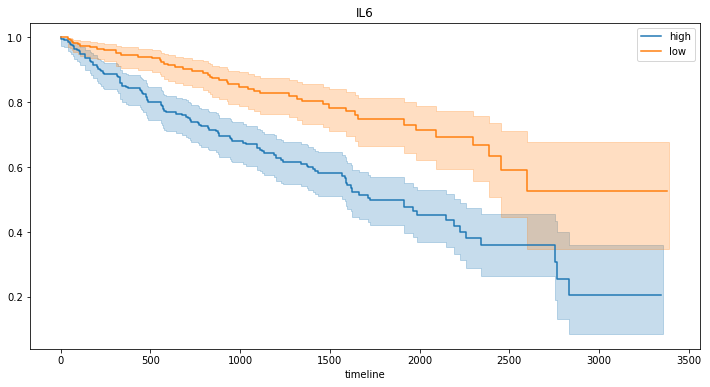

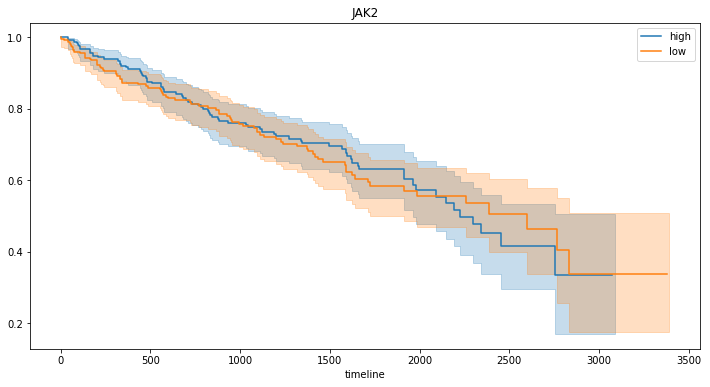

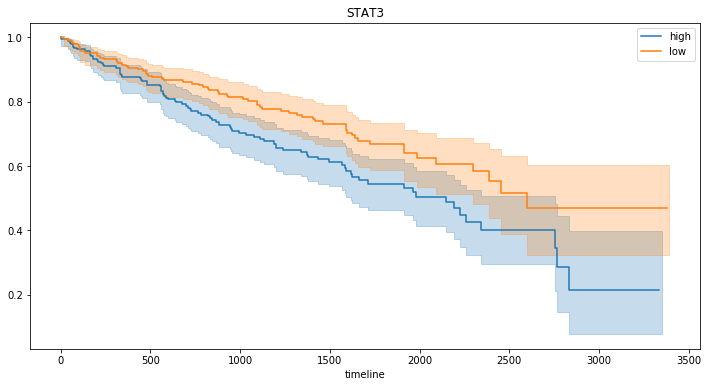

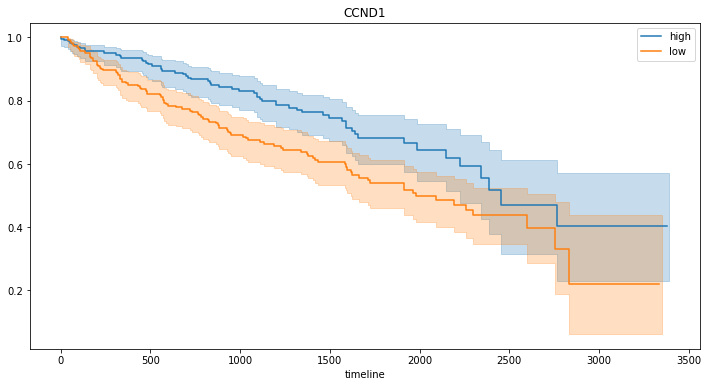

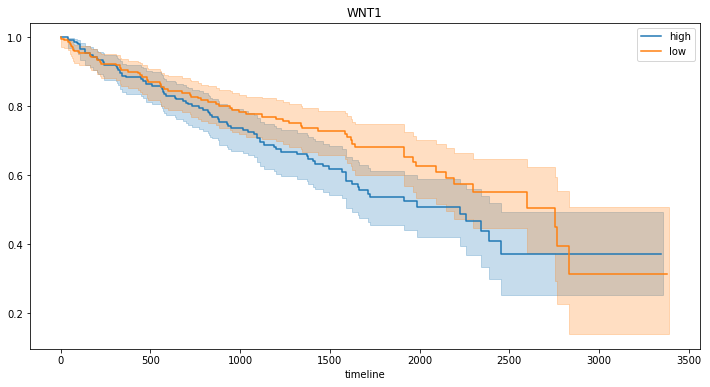

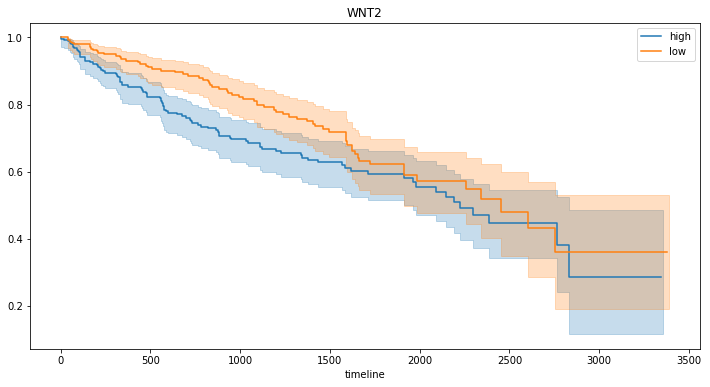

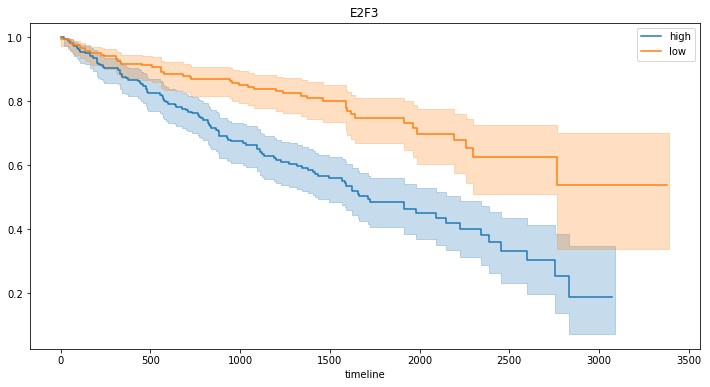

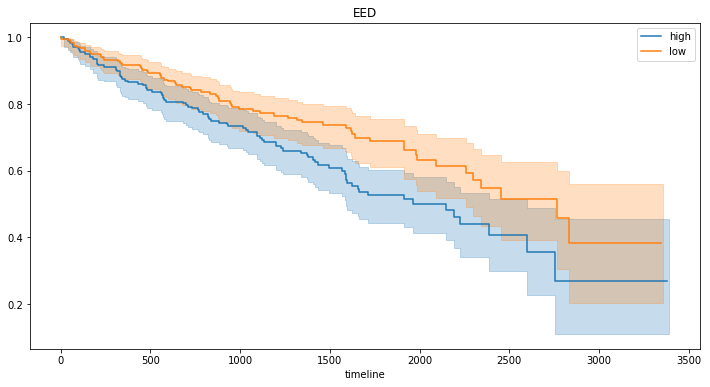

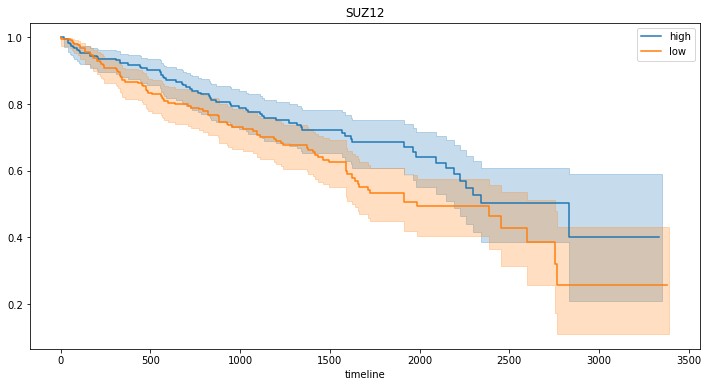

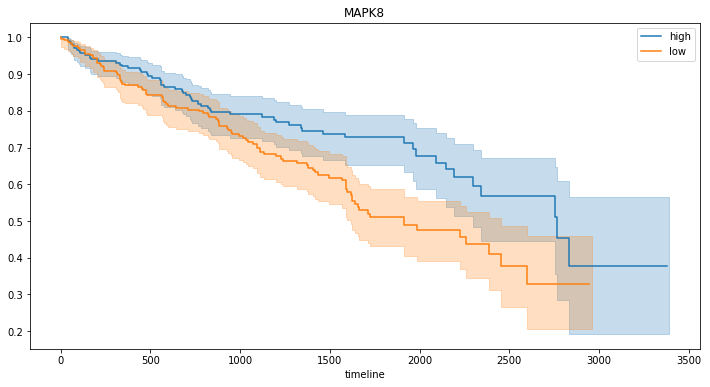

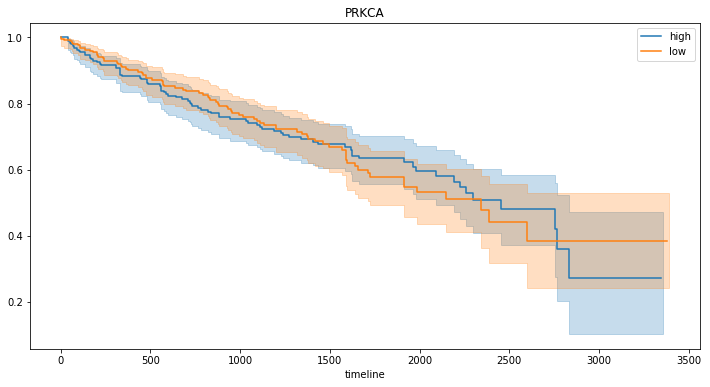

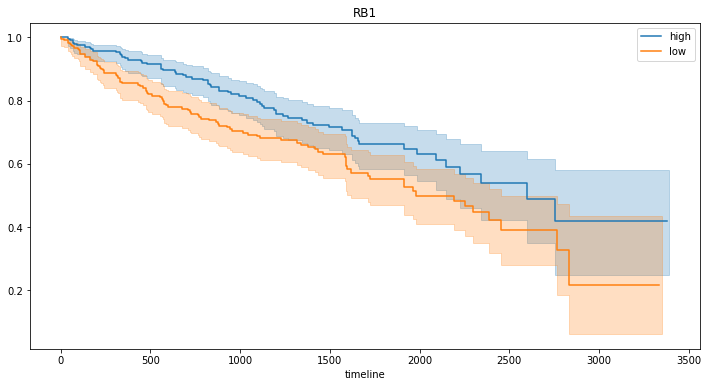

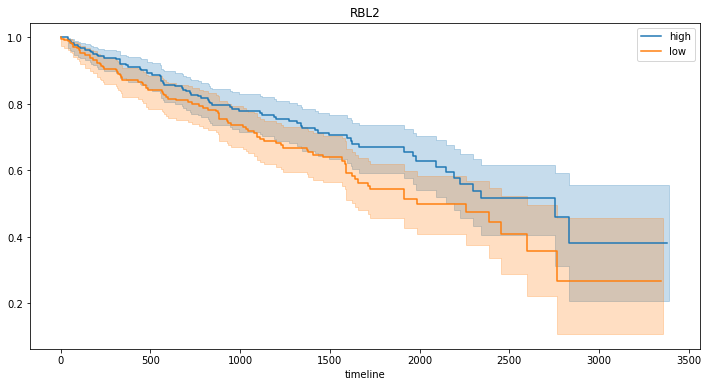

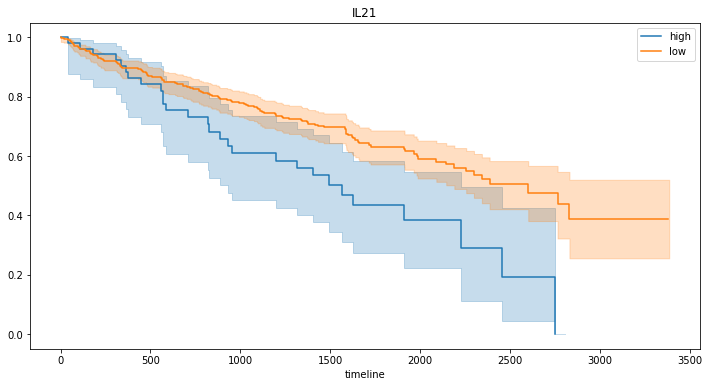

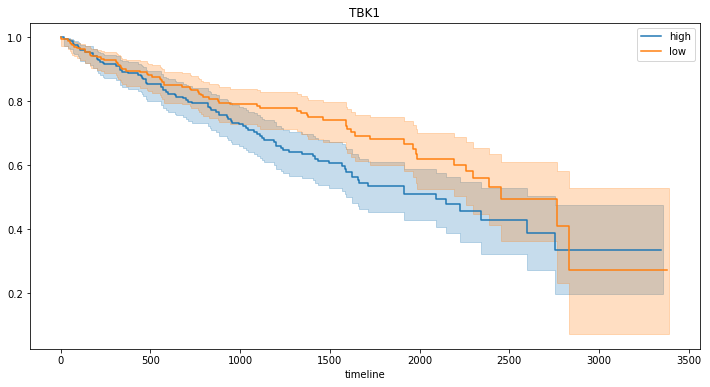

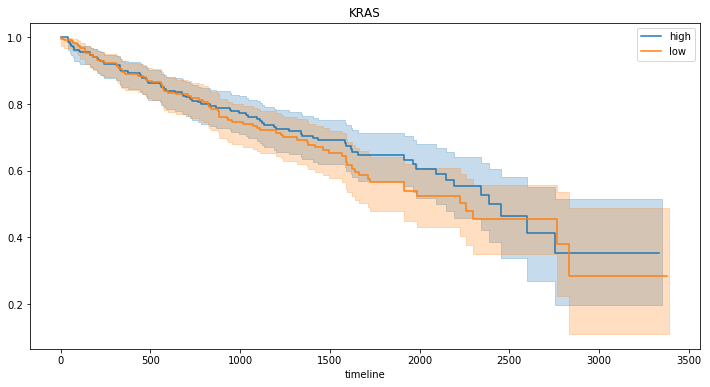

In [170]:
rna_hyp=rnaseq.loc[hypotheses]
h=rna_hyp.gt(rna_hyp.median(1),axis='rows').transpose()

# K-M plots for selected hypothesis genes
ts=[]
pval=[]
sig =[]
kmf = lifelines.KaplanMeierFitter()
for i in rna_hyp.index:
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes()
    ax.set_title(i)
    high = clinical[h.loc[:,i]]
    T1 = high['days_to_event']
    E1 = high['observed']
    kmf.fit(T1,event_observed=E1,label="high")
    kmf.plot(ax=ax)

    low = clinical[~h.loc[:,i]]
    T2 = low['days_to_event']
    E2 = low['observed']
    kmf.fit(T2,event_observed=E2,label="low")
    kmf.plot(ax=ax)
    
    res = lifelines.statistics.logrank_test(T1,T2,E1,E2)
    #print(i)
    pval.append(res.p_value)
    ts.append(res.test_statistic)
    sig.append(res.p_value<0.05/len(rna_hyp.index))
    #res.print_summary()
d={
    'nom p':pval,
    'chi-square':ts,
    #'mult p':list(map(lambda x: x*len(rna_hyp.index),pval)),
    'significant':sig
}
gene_logrank = pd.DataFrame(data=d,index=rna_hyp.index)
gene_logrank

In [134]:
for c in h.columns:
    h[c]=pd.get_dummies(h[c])[True]

n=532, number of events=160

         coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
IL6    0.5134     1.6709    0.1908  2.6909 0.0071      0.1394      0.8873  **
STAT3  0.4278     1.5339    0.1858  2.3026 0.0213      0.0637      0.7920   *
CCND1 -0.3041     0.7378    0.1725 -1.7635 0.0778     -0.6422      0.0339   .
WNT1  -0.0315     0.9690    0.1912 -0.1646 0.8693     -0.4063      0.3433    
E2F3   0.5927     1.8088    0.1915  3.0957 0.0020      0.2174      0.9679  **
EED    0.2713     1.3117    0.1789  1.5169 0.1293     -0.0792      0.6218    
SUZ12 -0.3081     0.7348    0.2108 -1.4618 0.1438     -0.7212      0.1050    
MAPK8 -0.0426     0.9583    0.2352 -0.1812 0.8562     -0.5035      0.4183    
PRKCA  0.0729     1.0756    0.1760  0.4143 0.6787     -0.2720      0.4178    
RBL2  -0.1753     0.8392    0.2104 -0.8334 0.4046     -0.5877      0.2370    
IL21   0.2454     1.2781    0.2212  1.1094 0.2673     -0.1881      0.6789    
TBK1  -0.0598     0.9419    0.1852 

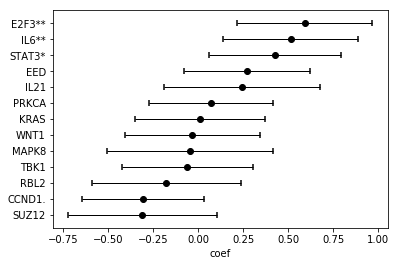

In [135]:
base=clinical[['days_to_event','observed']]
set_hazard_df=base.join(h)
cph = lifelines.CoxPHFitter()
cph.fit(set_hazard_df,duration_col='days_to_event',event_col='observed',step_size=.1)
cph.print_summary()
cph.plot()
hrg=np.exp(cph.hazards_.loc['coef'])

In [136]:
hrg

IL6      1.670923
STAT3    1.533901
CCND1    0.737751
WNT1     0.969018
E2F3     1.808845
EED      1.311673
SUZ12    0.734829
MAPK8    0.958291
PRKCA    1.075632
RBL2     0.839169
IL21     1.278103
TBK1     0.941949
KRAS     1.012506
Name: coef, dtype: float64

In [150]:
rnaseq.loc['RB1']


tcga-3z-a93z    1402.6284
tcga-6d-aa2e    1151.6460
tcga-a3-3306    2446.6874
tcga-a3-3307    3093.5780
tcga-a3-3308    2187.8656
tcga-a3-3311    2954.1437
tcga-a3-3313    2094.7612
tcga-a3-3316    2222.4490
tcga-a3-3317    2934.3658
tcga-a3-3319    1333.2129
tcga-a3-3320    2300.2743
tcga-a3-3322    2211.7647
tcga-a3-3323    1980.2410
tcga-a3-3324    2984.9703
tcga-a3-3325    2403.6869
tcga-a3-3326    1819.7621
tcga-a3-3328    1563.2612
tcga-a3-3329    2329.4775
tcga-a3-3331    2779.0608
tcga-a3-3335    2043.5876
tcga-a3-3343    1533.8861
tcga-a3-3346    1252.4212
tcga-a3-3347    2056.7345
tcga-a3-3349    1844.6602
tcga-a3-3351    2304.3107
tcga-a3-3352    2382.1143
tcga-a3-3357    3065.0651
tcga-a3-3358    1160.7143
tcga-a3-3359    2006.3435
tcga-a3-3362    1838.7978
                  ...    
tcga-cz-5986    1474.8657
tcga-cz-5987    2010.5820
tcga-cz-5988    1339.0358
tcga-cz-5989    1805.4630
tcga-dv-5565    1852.3680
tcga-dv-5566    2704.4410
tcga-dv-5567    2478.3862
tcga-dv-5568